In [1]:
!pip install -e .

Obtaining file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/_md
ERROR: file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/_md does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# py-tidymodels imports
from py_workflows import workflow
from py_parsnip import linear_reg, rand_forest, boost_tree
from py_rsample import initial_split, training, testing
from py_yardstick import metric_set, rmse, mae, r_squared, mape, smape

# Recipe imports
from py_recipes import recipe
from py_recipes.selectors import (
    all_numeric, all_nominal, all_predictors, all_outcomes,
    all_numeric_predictors, all_nominal_predictors,
    contains, starts_with, ends_with, matches,
    difference, one_of  # For excluding specific columns
)

from py_visualize import plot_forecast, plot_residuals

# Set random seed for reproducibility
np.random.seed(42)

# Recipes Demonstration Notebook

This notebook demonstrates various preprocessing techniques using py-recipes with the same forecasting data.

## Contents:
1. Data loading and splitting
2. Basic recipes
3. Feature engineering recipes
4. Model comparison with different recipes
5. Advanced recipe patterns

# 1. Import Data

In [3]:
# import raw data
raw_data = pd.read_csv('__data/refinery_margins.csv')

In [4]:
df = raw_data

# set date as index
#df = raw_data.set_index('date')

# convert date to datetime
df['date'] = pd.to_datetime(df['date'])
display(df)

,date,country,refinery_kbd,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,es_sider_cracking_med,es_sider_hydroskimming_med,urals_cracking_med,urals_hydroskimming_med,dubai_cracking_singapore,dubai_hydroskimming_singapore,tapis_hydroskimming_singapore,x50_50_hls_lls_cracking_usgc,x30_70_wcs_bakken_cracking_usmc,bakken_coking_usmc
0,2006-01-01,Algeria,450.0000,63.57,58.31,65.48,3.12,-2.51,5.30,-2.18,4.81,-0.17,6.80,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
1,2006-01-01,Denmark,172.9948,63.57,58.31,65.48,3.12,-2.51,5.30,-2.18,4.81,-0.17,6.80,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
2,2006-01-01,Germany,2270.5419,63.57,58.31,65.48,3.12,-2.51,5.30,-2.18,4.81,-0.17,6.80,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
3,2006-01-01,Italy,1859.7058,63.57,58.31,65.48,3.12,-2.51,5.30,-2.18,4.81,-0.17,6.80,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
4,2006-01-01,Netherlands,907.5555,63.57,58.31,65.48,3.12,-2.51,5.30,-2.18,4.81,-0.17,6.80,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,2021-12-01,Norway,224.7000,74.31,72.76,71.53,5.11,2.89,5.14,0.53,6.52,4.58,5.31,-0.31,8.24,-1.12,3.23,3.45,10.51,11.87
1916,2021-12-01,Romania,226.6026,74.31,72.76,71.53,5.11,2.89,5.14,0.53,6.52,4.58,5.31,-0.31,8.24,-1.12,3.23,3.45,10.51,11.87
1917,2021-12-01,Russian Federation,5924.5209,74.31,72.76,71.53,5.11,2.89,5.14,0.53,6.52,4.58,5.31,-0.31,8.24,-1.12,3.23,3.45,10.51,11.87
1918,2021-12-01,Turkey,773.1726,74.31,72.76,71.53,5.11,2.89,5.14,0.53,6.52,4.58,5.31,-0.31,8.24,-1.12,3.23,3.45,10.51,11.87


In [5]:
# rename target
df  = df.rename(columns={'refinery_kbd': 'target'})

# 2. Train/Test Split

In [6]:
# Create train/test split
split = initial_split(df, prop=0.75, seed=123)
train_data = training(split)
test_data = testing(split)

print(f"Training set: {train_data.shape[0]} rows")
print(f"Test set: {test_data.shape[0]} rows")
display(train_data.head(10))
display(test_data.tail(10))

Training set: 1440 rows
Test set: 480 rows


,date,country,target,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,es_sider_cracking_med,es_sider_hydroskimming_med,urals_cracking_med,urals_hydroskimming_med,dubai_cracking_singapore,dubai_hydroskimming_singapore,tapis_hydroskimming_singapore,x50_50_hls_lls_cracking_usgc,x30_70_wcs_bakken_cracking_usmc,bakken_coking_usmc
0,2006-01-01,Algeria,450.0000,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
1,2006-01-01,Denmark,172.9948,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
2,2006-01-01,Germany,2270.5419,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
3,2006-01-01,Italy,1859.7058,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
4,2006-01-01,Netherlands,907.5555,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
5,2006-01-01,Norway,316.9961,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
6,2006-01-01,Romania,330.4621,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
7,2006-01-01,Russian Federation,4319.2710,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
8,2006-01-01,Turkey,437.9177,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
9,2006-01-01,United Kingdom,1608.6955,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57


,date,country,target,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,es_sider_cracking_med,es_sider_hydroskimming_med,urals_cracking_med,urals_hydroskimming_med,dubai_cracking_singapore,dubai_hydroskimming_singapore,tapis_hydroskimming_singapore,x50_50_hls_lls_cracking_usgc,x30_70_wcs_bakken_cracking_usmc,bakken_coking_usmc
470,2021-12-01,Algeria,557.0000,74.31,72.76,71.53,5.11,2.89,5.14,0.53,6.52,4.58,5.31,-0.31,8.24,-1.12,3.23,3.45,10.51,11.87
471,2021-12-01,Denmark,156.5652,74.31,72.76,71.53,5.11,2.89,5.14,0.53,6.52,4.58,5.31,-0.31,8.24,-1.12,3.23,3.45,10.51,11.87
472,2021-12-01,Germany,1898.9548,74.31,72.76,71.53,5.11,2.89,5.14,0.53,6.52,4.58,5.31,-0.31,8.24,-1.12,3.23,3.45,10.51,11.87
473,2021-12-01,Italy,1246.4516,74.31,72.76,71.53,5.11,2.89,5.14,0.53,6.52,4.58,5.31,-0.31,8.24,-1.12,3.23,3.45,10.51,11.87
474,2021-12-01,Netherlands,951.1219,74.31,72.76,71.53,5.11,2.89,5.14,0.53,6.52,4.58,5.31,-0.31,8.24,-1.12,3.23,3.45,10.51,11.87
475,2021-12-01,Norway,224.7000,74.31,72.76,71.53,5.11,2.89,5.14,0.53,6.52,4.58,5.31,-0.31,8.24,-1.12,3.23,3.45,10.51,11.87
476,2021-12-01,Romania,226.6026,74.31,72.76,71.53,5.11,2.89,5.14,0.53,6.52,4.58,5.31,-0.31,8.24,-1.12,3.23,3.45,10.51,11.87
477,2021-12-01,Russian Federation,5924.5209,74.31,72.76,71.53,5.11,2.89,5.14,0.53,6.52,4.58,5.31,-0.31,8.24,-1.12,3.23,3.45,10.51,11.87
478,2021-12-01,Turkey,773.1726,74.31,72.76,71.53,5.11,2.89,5.14,0.53,6.52,4.58,5.31,-0.31,8.24,-1.12,3.23,3.45,10.51,11.87
479,2021-12-01,United Kingdom,1031.5206,74.31,72.76,71.53,5.11,2.89,5.14,0.53,6.52,4.58,5.31,-0.31,8.24,-1.12,3.23,3.45,10.51,11.87


# 3. Define Formula

Using dot notation to include all columns except target and date.

In [7]:
# Define formulas for nested vs global modeling
FORMULA_STR = "target ~ ."  # Dot notation - excludes date automatically
# FORMULA_GLOBAL = "refinery_kbd ~ ."  # Same formula, but fit_global adds 'country'

# Show group structure
print("=== Panel Data Structure ===")
print(f"Total countries: {train_data['country'].nunique()}")
print(f"Countries: {sorted(train_data['country'].unique())}")
print(f"\nObservations per country (train):")
print(train_data.groupby('country').size())
print(f"\nDate range per country (train):")
print(train_data.groupby('country')['date'].agg(['min', 'max']))

=== Panel Data Structure ===
Total countries: 10
Countries: ['Algeria', 'Denmark', 'Germany', 'Italy', 'Netherlands', 'Norway', 'Romania', 'Russian Federation', 'Turkey', 'United Kingdom']

Observations per country (train):
country
Algeria               144
Denmark               144
Germany               144
Italy                 144
Netherlands           144
Norway                144
Romania               144
Russian Federation    144
Turkey                144
United Kingdom        144
dtype: int64

Date range per country (train):
                          min        max
country                                 
Algeria            2006-01-01 2017-12-01
Denmark            2006-01-01 2017-12-01
Germany            2006-01-01 2017-12-01
Italy              2006-01-01 2017-12-01
Netherlands        2006-01-01 2017-12-01
Norway             2006-01-01 2017-12-01
Romania            2006-01-01 2017-12-01
Russian Federation 2006-01-01 2017-12-01
Turkey             2006-01-01 2017-12-01
United King

# 4a. Baseline Model (Model with fit_nested)

First, let's fit a baseline linear regression without any preprocessing.

In [8]:
# Baseline: No preprocessing
spec_baseline = linear_reg().set_engine("sklearn")
fit_baseline = spec_baseline.fit_nested(train_data, FORMULA_STR, group_col='country')
fit_baseline = fit_baseline.evaluate(test_data)

print("✓ Baseline model fitted successfully!")

# Extract outputs
outputs_baseline, coefs_baseline, stats_baseline = fit_baseline.extract_outputs()

# Plot forecast
fig = plot_forecast(fit_baseline, title="Baseline Model (No Preprocessing)")
fig.show()

display(outputs_baseline)
display(coefs_baseline)
display(stats_baseline)

✓ Baseline model fitted successfully!


,date,country,actuals,fitted,forecast,residuals,split,model,model_group_name,group
0,2006-01-01,Algeria,450.0000,442.990798,450.0000,7.009202,train,linear_reg,,global
1,2006-02-01,Algeria,436.0000,467.688053,436.0000,-31.688053,train,linear_reg,,global
2,2006-03-01,Algeria,429.0000,467.902732,429.0000,-38.902732,train,linear_reg,,global
3,2006-04-01,Algeria,451.0000,443.593545,451.0000,7.406455,train,linear_reg,,global
4,2006-05-01,Algeria,369.0000,500.903187,369.0000,-131.903187,train,linear_reg,,global
...,...,...,...,...,...,...,...,...,...,...
1915,2021-08-01,United Kingdom,1027.1426,1076.473114,1027.1426,-49.330514,test,linear_reg,,global
1916,2021-09-01,United Kingdom,943.2540,1086.384107,943.2540,-143.130107,test,linear_reg,,global
1917,2021-10-01,United Kingdom,909.4213,996.586780,909.4213,-87.165480,test,linear_reg,,global
1918,2021-11-01,United Kingdom,1038.5093,880.309527,1038.5093,158.199773,test,linear_reg,,global


,country,variable,coefficient,std_error,t_stat,p_value,vif,model,model_group_name,group,ci_0.025,ci_0.975
0,Algeria,Intercept,521.884060,66.844297,7.807458,1.955325e-12,NaN,linear_reg,,global,389.601162,654.166958
1,Algeria,brent,-21.637575,9.670579,-2.237464,2.701314e-02,1386.174670,linear_reg,,global,-40.775367,-2.499783
2,Algeria,dubai,11.553453,9.840396,1.174084,2.425757e-01,1351.579010,linear_reg,,global,-7.920402,31.027308
3,Algeria,wti,10.342232,4.137651,2.499542,1.372093e-02,192.494779,linear_reg,,global,2.153943,18.530521
4,Algeria,brent_cracking_nw_europe,-90.484282,50.724697,-1.783831,7.685824e-02,307.404407,linear_reg,,global,-190.866966,9.898402
...,...,...,...,...,...,...,...,...,...,...,...,...
175,United Kingdom,dubai_hydroskimming_singapore,73.192806,21.418695,3.417239,8.522862e-04,23.894469,linear_reg,,global,30.805838,115.579773
176,United Kingdom,tapis_hydroskimming_singapore,10.654505,14.463232,0.736661,4.626976e-01,25.184548,linear_reg,,global,-17.967805,39.276815
177,United Kingdom,x50_50_hls_lls_cracking_usgc,-20.700663,14.539734,-1.423730,1.569961e-01,23.766143,linear_reg,,global,-49.474369,8.073044
178,United Kingdom,x30_70_wcs_bakken_cracking_usmc,157.734898,43.241559,3.647762,3.857995e-04,1686.083705,linear_reg,,global,72.161123,243.308672


,country,split,metric,value,model,model_group_name,group
0,Algeria,train,rmse,76.993557,linear_reg,,global
1,Algeria,train,mae,54.947692,linear_reg,,global
2,Algeria,train,mape,11.173539,linear_reg,,global
3,Algeria,train,smape,13.515596,linear_reg,,global
4,Algeria,train,r_squared,0.387038,linear_reg,,global
...,...,...,...,...,...,...,...
255,United Kingdom,,model_type,linear_reg,linear_reg,,global
256,United Kingdom,,model_class,LinearRegression,linear_reg,,global
257,United Kingdom,train,n_obs_train,144,linear_reg,,global
258,United Kingdom,train,train_start_date,2006-01-01T00:00:00.000000000,linear_reg,,global


# 4b. Baseline Model (Workflow with fit_nested)

First, let's fit a baseline linear regression without any preprocessing.

In [9]:
# Baseline: No preprocessing
spec_baseline = linear_reg().set_engine("sklearn")
wf_baseline = workflow().add_formula(FORMULA_STR).add_model(spec_baseline).add_model_name("baseline").add_model_group_name("baseline_models")
fit_baseline = wf_baseline.fit_nested(train_data, group_col='country')
fit_baseline = fit_baseline.evaluate(test_data)

print("✓ Baseline model fitted successfully!")

# Extract outputs
outputs_baseline, coefs_baseline, stats_baseline = fit_baseline.extract_outputs()

display(outputs_baseline)
display(coefs_baseline)
display(stats_baseline)

# Plot forecast
fig = plot_forecast(fit_baseline, title="Baseline Model (No Preprocessing)")
fig.show()

# Extract preprocessed training data
processed_train = fit_baseline.extract_preprocessed_data(train_data, split='train')
processed_test = fit_baseline.extract_preprocessed_data(test_data, split='test')    

display(processed_train.tail(10))
display(processed_test.head(10))

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_workflows/workflow.py:576: UserWarning:

per_group_prep=True requires a recipe preprocessor. Workflow uses formula-only preprocessing. Falling back to per_group_prep=False.



✓ Baseline model fitted successfully!


,date,country,actuals,fitted,forecast,residuals,split,model,model_group_name,group
0,2006-01-01,Algeria,450.0000,442.990798,450.0000,7.009202,train,baseline,baseline_models,Algeria
1,2006-02-01,Algeria,436.0000,467.688053,436.0000,-31.688053,train,baseline,baseline_models,Algeria
2,2006-03-01,Algeria,429.0000,467.902732,429.0000,-38.902732,train,baseline,baseline_models,Algeria
3,2006-04-01,Algeria,451.0000,443.593545,451.0000,7.406455,train,baseline,baseline_models,Algeria
4,2006-05-01,Algeria,369.0000,500.903187,369.0000,-131.903187,train,baseline,baseline_models,Algeria
...,...,...,...,...,...,...,...,...,...,...
1915,2021-08-01,United Kingdom,1027.1426,1076.473114,1027.1426,-49.330514,test,baseline,baseline_models,United Kingdom
1916,2021-09-01,United Kingdom,943.2540,1086.384107,943.2540,-143.130107,test,baseline,baseline_models,United Kingdom
1917,2021-10-01,United Kingdom,909.4213,996.586780,909.4213,-87.165480,test,baseline,baseline_models,United Kingdom
1918,2021-11-01,United Kingdom,1038.5093,880.309527,1038.5093,158.199773,test,baseline,baseline_models,United Kingdom


,country,variable,coefficient,std_error,t_stat,p_value,vif,model,model_group_name,group,ci_0.025,ci_0.975
0,Algeria,Intercept,521.884060,66.844297,7.807458,1.955325e-12,NaN,baseline,baseline_models,Algeria,389.601162,654.166958
1,Algeria,brent,-21.637575,9.670579,-2.237464,2.701314e-02,1386.174670,baseline,baseline_models,Algeria,-40.775367,-2.499783
2,Algeria,dubai,11.553453,9.840396,1.174084,2.425757e-01,1351.579010,baseline,baseline_models,Algeria,-7.920402,31.027308
3,Algeria,wti,10.342232,4.137651,2.499542,1.372093e-02,192.494779,baseline,baseline_models,Algeria,2.153943,18.530521
4,Algeria,brent_cracking_nw_europe,-90.484282,50.724697,-1.783831,7.685824e-02,307.404407,baseline,baseline_models,Algeria,-190.866966,9.898402
...,...,...,...,...,...,...,...,...,...,...,...,...
175,United Kingdom,dubai_hydroskimming_singapore,73.192806,21.418695,3.417239,8.522862e-04,23.894469,baseline,baseline_models,United Kingdom,30.805838,115.579773
176,United Kingdom,tapis_hydroskimming_singapore,10.654505,14.463232,0.736661,4.626976e-01,25.184548,baseline,baseline_models,United Kingdom,-17.967805,39.276815
177,United Kingdom,x50_50_hls_lls_cracking_usgc,-20.700663,14.539734,-1.423730,1.569961e-01,23.766143,baseline,baseline_models,United Kingdom,-49.474369,8.073044
178,United Kingdom,x30_70_wcs_bakken_cracking_usmc,157.734898,43.241559,3.647762,3.857995e-04,1686.083705,baseline,baseline_models,United Kingdom,72.161123,243.308672


,country,split,metric,value,model,model_group_name,group
0,Algeria,train,rmse,76.993557,baseline,baseline_models,Algeria
1,Algeria,train,mae,54.947692,baseline,baseline_models,Algeria
2,Algeria,train,mape,11.173539,baseline,baseline_models,Algeria
3,Algeria,train,smape,13.515596,baseline,baseline_models,Algeria
4,Algeria,train,r_squared,0.387038,baseline,baseline_models,Algeria
...,...,...,...,...,...,...,...
255,United Kingdom,,model_type,linear_reg,baseline,baseline_models,United Kingdom
256,United Kingdom,,model_class,LinearRegression,baseline,baseline_models,United Kingdom
257,United Kingdom,train,n_obs_train,144,baseline,baseline_models,United Kingdom
258,United Kingdom,train,train_start_date,2006-01-01T00:00:00.000000000,baseline,baseline_models,United Kingdom


,date,country,target,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,...,es_sider_hydroskimming_med,urals_cracking_med,urals_hydroskimming_med,dubai_cracking_singapore,dubai_hydroskimming_singapore,tapis_hydroskimming_singapore,x50_50_hls_lls_cracking_usgc,x30_70_wcs_bakken_cracking_usmc,bakken_coking_usmc,split
1430,2017-03-01,United Kingdom,1093.3000,51.97,51.16,49.58,4.32,0.75,5.74,1.12,...,3.29,6.22,1.70,5.25,0.65,6.04,3.02,10.19,11.97,train
1431,2017-04-01,United Kingdom,1116.4227,52.98,52.45,51.06,6.29,2.34,7.15,2.09,...,4.89,7.03,2.30,5.65,0.98,7.07,4.07,13.25,15.33,train
1432,2017-05-01,United Kingdom,1080.6523,50.87,50.31,48.50,5.64,2.14,6.11,1.48,...,4.50,6.75,2.52,4.53,0.45,6.01,3.41,12.29,14.11,train
1433,2017-06-01,United Kingdom,1131.2513,46.89,46.44,45.17,6.57,3.37,6.77,2.69,...,5.69,6.96,3.53,5.54,2.05,6.32,4.19,12.29,13.94,train
1434,2017-07-01,United Kingdom,1091.8406,48.69,47.63,46.65,6.80,3.30,6.90,2.98,...,5.28,7.54,3.63,6.32,2.58,6.52,3.97,14.43,16.14,train
1435,2017-08-01,United Kingdom,1150.9445,51.37,50.43,48.03,7.79,3.57,7.54,2.95,...,4.98,7.80,3.17,7.26,2.89,7.28,3.96,16.84,18.92,train
1436,2017-09-01,United Kingdom,1150.3527,55.16,53.86,49.83,8.17,3.52,9.09,3.98,...,4.67,9.14,3.95,7.93,3.38,6.77,3.22,17.86,20.03,train
1437,2017-10-01,United Kingdom,1117.6226,57.62,55.58,51.56,5.92,1.94,6.85,2.26,...,3.47,6.99,2.10,6.52,2.09,6.15,2.60,18.97,21.42,train
1438,2017-11-01,United Kingdom,1061.8833,62.57,60.58,56.65,5.84,1.44,5.85,0.94,...,2.93,5.59,0.63,5.77,1.61,5.59,2.02,17.39,19.45,train
1439,2017-12-01,United Kingdom,1079.9226,64.21,61.41,57.94,3.90,-0.36,3.52,-1.30,...,1.49,4.69,-0.54,6.05,1.50,5.26,1.43,13.39,15.35,train


,date,country,target,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,...,es_sider_hydroskimming_med,urals_cracking_med,urals_hydroskimming_med,dubai_cracking_singapore,dubai_hydroskimming_singapore,tapis_hydroskimming_singapore,x50_50_hls_lls_cracking_usgc,x30_70_wcs_bakken_cracking_usmc,bakken_coking_usmc,split
0,2018-01-01,Algeria,569.0,68.99,66.02,63.67,3.60,-0.96,3.35,-1.85,...,0.82,4.42,-1.29,5.58,0.54,4.50,0.26,11.41,13.53,test
1,2018-02-01,Algeria,601.0,65.42,62.79,62.17,4.37,-0.12,5.27,0.31,...,1.37,6.56,1.13,6.43,1.47,6.29,2.36,7.80,9.69,test
2,2018-03-01,Algeria,612.0,66.45,63.29,62.76,2.81,-1.24,4.51,-0.04,...,1.57,6.58,0.98,6.33,1.18,5.57,1.75,9.23,11.12,test
3,2018-04-01,Algeria,640.0,71.63,68.43,66.32,4.38,-0.96,6.09,0.23,...,1.77,6.92,0.49,5.50,-0.02,4.65,0.71,12.91,15.04,test
4,2018-05-01,Algeria,519.0,76.65,73.66,69.98,4.78,-0.24,5.86,0.34,...,2.22,6.44,0.44,5.28,0.21,4.78,1.11,17.65,20.00,test
5,2018-06-01,Algeria,510.0,75.19,73.22,67.52,5.17,0.89,6.11,1.26,...,3.69,5.97,0.85,3.75,-0.28,4.66,1.84,16.53,18.62,test
6,2018-07-01,Algeria,430.0,74.44,72.72,70.84,5.19,1.09,6.63,2.14,...,3.98,6.86,2.09,4.40,1.05,4.78,2.23,14.49,16.15,test
7,2018-08-01,Algeria,630.0,73.13,72.13,67.99,7.51,2.78,7.77,2.58,...,5.70,8.67,3.31,5.72,1.55,7.11,3.99,16.73,18.66,test
8,2018-09-01,Algeria,666.0,78.86,77.02,70.21,4.04,-0.63,4.48,-0.71,...,1.68,4.74,-0.94,5.07,0.13,5.08,1.34,16.59,18.82,test
9,2018-10-01,Algeria,611.0,80.47,78.96,70.75,2.02,-0.93,4.39,0.89,...,1.46,5.18,0.19,4.67,0.99,3.65,0.82,13.11,14.75,test


## Inspecting Preprocessed Data

The `.extract_preprocessed_data()` method lets you see what data the models actually see after recipe transformations. This is especially useful with per-group preprocessing where each group may have different transformations.

**Key Points:**
- Shows the data AFTER recipe steps are applied
- Useful for verifying normalization, scaling, feature engineering
- Works with both per-group and shared preprocessing
- Returns a DataFrame with the group column and metadata (date, split)

In [10]:
# Extract preprocessed training data
processed_train = fit_baseline.extract_preprocessed_data(train_data, split='train')

print(f"Preprocessed training data shape: {processed_train.shape}")
print(f"\nColumns: {list(processed_train.columns)}")
print(f"\nFirst few rows:")
display(processed_train.head(10))

# Compare preprocessing statistics across groups
print(f"\n{'='*70}")
print("Preprocessing Statistics by Group:")
print(f"{'='*70}")

for group in processed_train['country'].unique():
    group_data = processed_train[processed_train['country'] == group]
    print(f"\n{group}:")
    print(f"  Rows: {len(group_data)}")
    print(f"  refinery_kbd mean: {group_data['target'].mean():.2f}")
    print(f"  (Note: Since this is baseline with no preprocessing, values should match original data)")

Preprocessed training data shape: (1440, 21)

Columns: ['date', 'country', 'target', 'brent', 'dubai', 'wti', 'brent_cracking_nw_europe', 'brent_hydroskimming_nw_europe', 'urals_cracking_nw_europe', 'urals_hydroskimming_nw_europe', 'es_sider_cracking_med', 'es_sider_hydroskimming_med', 'urals_cracking_med', 'urals_hydroskimming_med', 'dubai_cracking_singapore', 'dubai_hydroskimming_singapore', 'tapis_hydroskimming_singapore', 'x50_50_hls_lls_cracking_usgc', 'x30_70_wcs_bakken_cracking_usmc', 'bakken_coking_usmc', 'split']

First few rows:


,date,country,target,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,...,es_sider_hydroskimming_med,urals_cracking_med,urals_hydroskimming_med,dubai_cracking_singapore,dubai_hydroskimming_singapore,tapis_hydroskimming_singapore,x50_50_hls_lls_cracking_usgc,x30_70_wcs_bakken_cracking_usmc,bakken_coking_usmc,split
0,2006-01-01,Algeria,450.0,63.57,58.31,65.48,3.12,-2.51,5.30,-2.18,...,-0.17,6.80,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57,train
1,2006-02-01,Algeria,436.0,59.92,57.58,61.62,3.03,-0.94,5.78,0.02,...,2.57,8.49,1.62,2.35,-2.29,-0.48,-4.00,1.95,3.93,train
2,2006-03-01,Algeria,429.0,62.25,57.65,62.89,4.59,-0.83,7.97,1.24,...,1.15,9.57,2.16,6.43,0.86,2.99,-1.09,9.40,12.18,train
3,2006-04-01,Algeria,451.0,70.44,64.06,69.41,5.02,-2.44,8.31,0.05,...,-1.78,9.09,0.19,8.00,0.69,4.11,-0.79,15.74,19.40,train
4,2006-05-01,Algeria,369.0,70.19,64.91,70.93,7.14,-0.91,10.66,1.99,...,1.35,11.75,2.33,11.29,2.13,9.26,3.02,15.07,18.70,train
5,2006-06-01,Algeria,387.0,68.86,65.08,70.93,9.00,0.25,11.39,1.43,...,1.66,11.62,1.64,7.99,-1.00,7.89,2.04,15.99,20.25,train
6,2006-07-01,Algeria,439.0,73.90,69.05,74.40,7.31,-2.07,9.34,-1.28,...,0.28,10.43,0.22,5.24,-3.40,4.10,-2.27,16.92,21.31,train
7,2006-08-01,Algeria,431.0,73.61,68.78,73.04,6.00,-2.03,8.24,-1.37,...,0.08,10.03,-0.24,4.50,-4.67,3.04,-4.09,13.67,17.54,train
8,2006-09-01,Algeria,461.0,62.77,59.77,63.82,4.67,-1.93,6.93,-0.43,...,-0.50,8.25,-0.25,3.88,-3.77,1.96,-4.31,1.03,3.41,train
9,2006-10-01,Algeria,474.0,58.38,56.50,58.85,4.55,-1.27,7.44,0.76,...,-0.40,7.91,0.16,3.54,-2.56,3.05,-2.55,3.79,6.46,train



Preprocessing Statistics by Group:

Algeria:
  Rows: 144
  refinery_kbd mean: 490.51
  (Note: Since this is baseline with no preprocessing, values should match original data)

Denmark:
  Rows: 144
  refinery_kbd mean: 151.96
  (Note: Since this is baseline with no preprocessing, values should match original data)

Germany:
  Rows: 144
  refinery_kbd mean: 2011.02
  (Note: Since this is baseline with no preprocessing, values should match original data)

Italy:
  Rows: 144
  refinery_kbd mean: 1531.74
  (Note: Since this is baseline with no preprocessing, values should match original data)

Netherlands:
  Rows: 144
  refinery_kbd mean: 1018.84
  (Note: Since this is baseline with no preprocessing, values should match original data)

Norway:
  Rows: 144
  refinery_kbd mean: 291.04
  (Note: Since this is baseline with no preprocessing, values should match original data)

Romania:
  Rows: 144
  refinery_kbd mean: 226.10
  (Note: Since this is baseline with no preprocessing, values should m

### Extracting Preprocessed Test Data

You can also extract preprocessed test data after calling `.evaluate()`. This shows how test data is transformed using the training statistics (e.g., training means/stds for normalization).

In [11]:
# Extract preprocessed test data
processed_test = fit_baseline.extract_preprocessed_data(test_data, split='test')

print(f"Preprocessed test data shape: {processed_test.shape}")
print(f"\nFirst few rows:")
display(processed_test.head())

# Verify split column
print(f"\nSplit values: {processed_test['split'].unique()}")

Preprocessed test data shape: (480, 21)

First few rows:


,date,country,target,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,...,es_sider_hydroskimming_med,urals_cracking_med,urals_hydroskimming_med,dubai_cracking_singapore,dubai_hydroskimming_singapore,tapis_hydroskimming_singapore,x50_50_hls_lls_cracking_usgc,x30_70_wcs_bakken_cracking_usmc,bakken_coking_usmc,split
0,2018-01-01,Algeria,569.0,68.99,66.02,63.67,3.60,-0.96,3.35,-1.85,...,0.82,4.42,-1.29,5.58,0.54,4.50,0.26,11.41,13.53,test
1,2018-02-01,Algeria,601.0,65.42,62.79,62.17,4.37,-0.12,5.27,0.31,...,1.37,6.56,1.13,6.43,1.47,6.29,2.36,7.80,9.69,test
2,2018-03-01,Algeria,612.0,66.45,63.29,62.76,2.81,-1.24,4.51,-0.04,...,1.57,6.58,0.98,6.33,1.18,5.57,1.75,9.23,11.12,test
3,2018-04-01,Algeria,640.0,71.63,68.43,66.32,4.38,-0.96,6.09,0.23,...,1.77,6.92,0.49,5.50,-0.02,4.65,0.71,12.91,15.04,test
4,2018-05-01,Algeria,519.0,76.65,73.66,69.98,4.78,-0.24,5.86,0.34,...,2.22,6.44,0.44,5.28,0.21,4.78,1.11,17.65,20.00,test



Split values: ['test']


# 5. Recipe Pattern 1: Normalization

Normalize numeric predictors to improve model performance.

In [12]:
# Recipe with normalization
rec_normalize = (
    recipe()
    .step_normalize(all_numeric_predictors())
)

# Workflow with recipe
wf_normalize = (
    workflow()
    .add_recipe(rec_normalize)
    .add_model(linear_reg().set_engine("sklearn"))
    .add_model_name("normalize")
    .add_model_group_name("normalize_models")
)

# Fit and evaluate
fit_normalize = wf_normalize.fit_nested(train_data, group_col='country')
fit_normalize = fit_normalize.evaluate(test_data)

print("✓ Normalized model fitted successfully!")

# Extract outputs
outputs_normalize, coefs_normalize, stats_normalize = fit_normalize.extract_outputs()

display(outputs_normalize)
display(coefs_normalize)
display(stats_normalize)

# Plot forecast
fig = plot_forecast(fit_normalize, title="Baseline Model (No Preprocessing)")
fig.show()

# Extract preprocessed training data
processed_train = fit_normalize.extract_preprocessed_data(train_data, split='train')
processed_test = fit_normalize.extract_preprocessed_data(test_data, split='test')    

display(processed_train.tail(10))
display(processed_test.head(10))

✓ Normalized model fitted successfully!


,date,country,actuals,fitted,forecast,residuals,split,model,model_group_name,group
0,2006-01-01,Algeria,450.0000,442.990798,450.0000,7.009202,train,normalize,normalize_models,Algeria
1,2006-02-01,Algeria,436.0000,467.688053,436.0000,-31.688053,train,normalize,normalize_models,Algeria
2,2006-03-01,Algeria,429.0000,467.902732,429.0000,-38.902732,train,normalize,normalize_models,Algeria
3,2006-04-01,Algeria,451.0000,443.593545,451.0000,7.406455,train,normalize,normalize_models,Algeria
4,2006-05-01,Algeria,369.0000,500.903187,369.0000,-131.903187,train,normalize,normalize_models,Algeria
...,...,...,...,...,...,...,...,...,...,...
1915,2021-08-01,United Kingdom,1027.1426,1076.473114,1027.1426,-49.330514,test,normalize,normalize_models,United Kingdom
1916,2021-09-01,United Kingdom,943.2540,1086.384107,943.2540,-143.130107,test,normalize,normalize_models,United Kingdom
1917,2021-10-01,United Kingdom,909.4213,996.586780,909.4213,-87.165480,test,normalize,normalize_models,United Kingdom
1918,2021-11-01,United Kingdom,1038.5093,880.309527,1038.5093,158.199773,test,normalize,normalize_models,United Kingdom


,country,variable,coefficient,std_error,t_stat,p_value,vif,model,model_group_name,group,ci_0.025,ci_0.975
0,Algeria,Intercept,490.506944,6.859131,71.511527,0.000000,NaN,normalize,normalize_models,Algeria,476.932925,504.080963
1,Algeria,brent,-571.392054,255.374829,-2.237464,0.027013,1386.174670,normalize,normalize_models,Algeria,-1076.771334,-66.012774
2,Algeria,dubai,296.066341,252.167916,1.174084,0.242576,1351.579010,normalize,normalize_models,Algeria,-202.966552,795.099234
3,Algeria,wti,237.869652,95.165293,2.499542,0.013721,192.494779,normalize,normalize_models,Algeria,49.540335,426.198968
4,Algeria,brent_cracking_nw_europe,-214.524964,120.260818,-1.783831,0.076858,307.404407,normalize,normalize_models,Algeria,-452.517588,23.467660
...,...,...,...,...,...,...,...,...,...,...,...,...
175,United Kingdom,dubai_hydroskimming_singapore,145.137232,42.472072,3.417239,0.000852,23.894469,normalize,normalize_models,United Kingdom,61.086251,229.188213
176,United Kingdom,tapis_hydroskimming_singapore,32.121054,43.603549,0.736661,0.462698,25.184548,normalize,normalize_models,United Kingdom,-54.169087,118.411195
177,United Kingdom,x50_50_hls_lls_cracking_usgc,-60.306191,42.357870,-1.423730,0.156996,23.766143,normalize,normalize_models,United Kingdom,-144.131170,23.518789
178,United Kingdom,x30_70_wcs_bakken_cracking_usmc,1301.429852,356.774923,3.647762,0.000386,1686.083705,normalize,normalize_models,United Kingdom,595.382768,2007.476935


,country,split,metric,value,model,model_group_name,group
0,Algeria,train,rmse,76.993557,normalize,normalize_models,Algeria
1,Algeria,train,mae,54.947692,normalize,normalize_models,Algeria
2,Algeria,train,mape,11.173539,normalize,normalize_models,Algeria
3,Algeria,train,smape,13.515596,normalize,normalize_models,Algeria
4,Algeria,train,r_squared,0.387038,normalize,normalize_models,Algeria
...,...,...,...,...,...,...,...
255,United Kingdom,,model_type,linear_reg,normalize,normalize_models,United Kingdom
256,United Kingdom,,model_class,LinearRegression,normalize,normalize_models,United Kingdom
257,United Kingdom,train,n_obs_train,144,normalize,normalize_models,United Kingdom
258,United Kingdom,train,train_start_date,2006-01-01T00:00:00.000000000,normalize,normalize_models,United Kingdom


,date,country,target,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,...,es_sider_hydroskimming_med,urals_cracking_med,urals_hydroskimming_med,dubai_cracking_singapore,dubai_hydroskimming_singapore,tapis_hydroskimming_singapore,x50_50_hls_lls_cracking_usgc,x30_70_wcs_bakken_cracking_usmc,bakken_coking_usmc,split
1430,2017-03-01,United Kingdom,1093.3000,-1.057443,-1.014581,-1.112604,-0.311597,0.378881,-0.052598,0.769716,...,0.767560,-0.131079,1.016494,0.008706,0.635034,0.793128,1.097357,-0.332386,-0.356835,train
1431,2017-04-01,United Kingdom,1116.4227,-1.019196,-0.964241,-1.048256,0.519328,1.098069,0.507125,1.207120,...,1.454312,0.158431,1.270942,0.195133,0.801453,1.134777,1.457779,0.038490,0.043274,train
1432,2017-05-01,United Kingdom,1080.6523,-1.099098,-1.047751,-1.159561,0.245165,1.007605,0.094280,0.932051,...,1.286916,0.058354,1.364239,-0.326861,0.534173,0.783177,1.231228,-0.077863,-0.102004,train
1433,2017-06-01,United Kingdom,1131.2513,-1.249813,-1.198771,-1.304345,0.637429,1.563958,0.356277,1.477679,...,1.797689,0.133412,1.792559,0.143865,1.341055,0.886004,1.498971,-0.077863,-0.122247,train
1434,2017-07-01,United Kingdom,1091.8406,-1.181650,-1.152333,-1.239997,0.734440,1.532296,0.407883,1.608449,...,1.621708,0.340715,1.834967,0.507397,1.608334,0.952343,1.423454,0.181507,0.139729,train
1435,2017-08-01,United Kingdom,1150.9445,-1.080163,-1.043068,-1.179996,1.152011,1.654422,0.661942,1.594921,...,1.492942,0.433644,1.639891,0.945498,1.764667,1.204434,1.420021,0.473602,0.470771,train
1436,2017-09-01,United Kingdom,1150.3527,-0.936643,-0.909219,-1.101735,1.312291,1.631806,1.277240,2.059381,...,1.359884,0.912586,1.970672,1.257762,2.011775,1.035268,1.166009,0.597227,0.602950,train
1437,2017-10-01,United Kingdom,1117.6226,-0.843487,-0.842099,-1.026517,0.363266,0.917141,0.388035,1.283778,...,0.844819,0.144134,1.186126,0.600610,1.361227,0.829615,0.953188,0.731761,0.768472,train
1438,2017-11-01,United Kingdom,1061.8833,-0.656040,-0.646983,-0.805211,0.329523,0.690981,-0.008932,0.688548,...,0.613040,-0.356253,0.562730,0.251061,1.119162,0.643864,0.754098,0.540263,0.533884,train
1439,2017-12-01,United Kingdom,1079.9226,-0.593936,-0.614594,-0.749124,-0.488748,-0.123194,-0.933864,-0.321540,...,-0.005037,-0.677930,0.066557,0.381559,1.063689,0.534403,0.551575,0.055458,0.045656,train


,date,country,target,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,...,es_sider_hydroskimming_med,urals_cracking_med,urals_hydroskimming_med,dubai_cracking_singapore,dubai_hydroskimming_singapore,tapis_hydroskimming_singapore,x50_50_hls_lls_cracking_usgc,x30_70_wcs_bakken_cracking_usmc,bakken_coking_usmc,split
0,2018-01-01,Algeria,569.0,-0.412926,-0.434697,-0.499991,-0.615285,-0.394586,-1.001348,-0.569552,...,-0.292615,-0.774433,-0.251503,0.162508,0.579561,0.282312,0.149961,-0.184520,-0.171070,test
1,2018-02-01,Algeria,601.0,-0.548116,-0.560742,-0.565209,-0.290507,-0.014638,-0.239172,0.404461,...,-0.056544,-0.009556,0.774769,0.558664,1.048560,0.876053,0.870806,-0.622057,-0.628337,test
2,2018-03-01,Algeria,612.0,-0.509111,-0.541230,-0.539557,-0.948498,-0.521236,-0.540867,0.246635,...,0.029300,-0.002408,0.711157,0.512057,0.902313,0.637230,0.661418,-0.448739,-0.458053,test
3,2018-04-01,Algeria,640.0,-0.312954,-0.340651,-0.384773,-0.286289,-0.394586,0.086340,0.368386,...,0.115144,0.119115,0.503358,0.125223,0.297152,0.332067,0.304428,-0.002719,0.008741,test
4,2018-05-01,Algeria,519.0,-0.122856,-0.136559,-0.225642,-0.117574,-0.068916,-0.004962,0.417989,...,0.308294,-0.052446,0.482154,0.022688,0.413141,0.375188,0.441732,0.571775,0.599378,test
5,2018-06-01,Algeria,510.0,-0.178143,-0.153730,-0.332599,0.046924,0.442205,0.094280,0.832846,...,0.939248,-0.220433,0.656027,-0.690392,0.166034,0.335384,0.692311,0.436030,0.435047,test
6,2018-07-01,Algeria,430.0,-0.206545,-0.173241,-0.188250,0.055360,0.532669,0.300702,1.229667,...,1.063722,0.097670,1.181885,-0.387449,0.836754,0.375188,0.826182,0.188779,0.140920,test
7,2018-08-01,Algeria,630.0,-0.256152,-0.196265,-0.312164,1.033910,1.297089,0.753244,1.428077,...,1.801981,0.744599,1.699262,0.227757,1.088904,1.148045,1.430319,0.460270,0.439811,test
8,2018-09-01,Algeria,666.0,-0.039167,-0.005442,-0.215642,-0.429698,-0.245321,-0.552776,-0.055490,...,0.076515,-0.660059,-0.103075,-0.075185,0.372797,0.474697,0.520681,0.443302,0.458863,test
9,2018-10-01,Algeria,611.0,0.021800,0.070263,-0.192163,-1.281711,-0.381016,-0.588503,0.666002,...,-0.017914,-0.502795,0.376135,-0.261612,0.806496,0.000369,0.342187,0.021522,-0.025792,test


# Complex Recipe

In [13]:
# Complex recipe with multiple steps
rec_complex = (
    recipe()
    # 1. Handle missing values
    .step_impute_median(all_numeric_predictors())
    # 2. Remove highly correlated features
    # .step_corr(all_numeric_predictors(), threshold=0.9)
    # 3. Normalize remaining features
    .step_normalize(all_numeric_predictors())
    # 4. Add polynomial features
    .step_poly(all_numeric_predictors(), degree=2, include_interactions=False)
    # .step_poly("totaltar", degree=2)
)

# Workflow
wf_complex = (
    workflow()
    .add_recipe(rec_complex)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_complex = wf_complex.fit_nested(train_data, group_col='country')
fit_complex = fit_complex.evaluate(test_data)

print("✓ Complex recipe model fitted successfully!")

outputs_complex, coefs_complex, stats_complex = fit_complex.extract_outputs()

display(outputs_complex)
display(coefs_complex)
display(stats_complex)

# Plot forecast
fig = plot_forecast(fit_complex, title="Complex Recipe")
fig.show()

# Extract preprocessed training data
processed_train = fit_complex.extract_preprocessed_data(train_data, split='train')
processed_test = fit_complex.extract_preprocessed_data(test_data, split='test')    

display(processed_train.tail(10))
display(processed_test.head(10))

✓ Complex recipe model fitted successfully!


,date,country,actuals,fitted,forecast,residuals,split,model,model_group_name,group
0,2006-01-01,Algeria,450.0000,503.811421,450.0000,-53.811421,train,linear_reg,,Algeria
1,2006-02-01,Algeria,436.0000,489.510469,436.0000,-53.510469,train,linear_reg,,Algeria
2,2006-03-01,Algeria,429.0000,534.865469,429.0000,-105.865469,train,linear_reg,,Algeria
3,2006-04-01,Algeria,451.0000,408.666146,451.0000,42.333854,train,linear_reg,,Algeria
4,2006-05-01,Algeria,369.0000,428.782312,369.0000,-59.782312,train,linear_reg,,Algeria
...,...,...,...,...,...,...,...,...,...,...
1915,2021-08-01,United Kingdom,1027.1426,1376.217568,1027.1426,-349.074968,test,linear_reg,,United Kingdom
1916,2021-09-01,United Kingdom,943.2540,1394.109982,943.2540,-450.855982,test,linear_reg,,United Kingdom
1917,2021-10-01,United Kingdom,909.4213,1402.411351,909.4213,-492.990051,test,linear_reg,,United Kingdom
1918,2021-11-01,United Kingdom,1038.5093,1419.820768,1038.5093,-381.311468,test,linear_reg,,United Kingdom


,country,variable,coefficient,std_error,t_stat,p_value,vif,model,model_group_name,group,ci_0.025,ci_0.975
0,Algeria,Intercept,531.023988,15.965504,33.260709,0.000000,NaN,linear_reg,,Algeria,499.428725,562.619251
1,Algeria,brent_pow_2,-101.404733,68.451965,-1.481400,0.140997,69.049993,linear_reg,,Algeria,-236.869159,34.059692
2,Algeria,dubai_pow_2,78.593170,66.185855,1.187462,0.237279,67.224130,linear_reg,,Algeria,-52.386692,209.573032
3,Algeria,wti_pow_2,26.007455,22.255648,1.168578,0.244780,11.919719,linear_reg,,Algeria,-18.035817,70.050727
4,Algeria,brent_cracking_nw_europe_pow_2,7.932993,19.536533,0.406059,0.685388,17.025369,linear_reg,,Algeria,-30.729231,46.595216
...,...,...,...,...,...,...,...,...,...,...,...,...
175,United Kingdom,dubai_hydroskimming_singapore_pow_2,8.157221,13.652155,0.597504,0.551243,2.079858,linear_reg,,United Kingdom,-18.859992,35.174434
176,United Kingdom,tapis_hydroskimming_singapore_pow_2,2.686810,20.664313,0.130022,0.896757,4.187309,linear_reg,,United Kingdom,-38.207258,43.580878
177,United Kingdom,x50_50_hls_lls_cracking_usgc_pow_2,-15.791358,22.172768,-0.712196,0.477660,3.937263,linear_reg,,United Kingdom,-59.670613,28.087898
178,United Kingdom,x30_70_wcs_bakken_cracking_usmc_pow_2,-48.403242,82.558141,-0.586293,0.558728,68.011508,linear_reg,,United Kingdom,-211.783375,114.976891


,country,split,metric,value,model,model_group_name,group
0,Algeria,train,rmse,77.108902,linear_reg,,Algeria
1,Algeria,train,mae,58.670591,linear_reg,,Algeria
2,Algeria,train,mape,12.127538,linear_reg,,Algeria
3,Algeria,train,smape,14.32266,linear_reg,,Algeria
4,Algeria,train,r_squared,0.3852,linear_reg,,Algeria
...,...,...,...,...,...,...,...
255,United Kingdom,,model_type,linear_reg,linear_reg,,United Kingdom
256,United Kingdom,,model_class,LinearRegression,linear_reg,,United Kingdom
257,United Kingdom,train,n_obs_train,144,linear_reg,,United Kingdom
258,United Kingdom,train,train_start_date,2006-01-01T00:00:00.000000000,linear_reg,,United Kingdom


,date,country,target,brent_pow_2,dubai_pow_2,wti_pow_2,brent_cracking_nw_europe_pow_2,brent_hydroskimming_nw_europe_pow_2,urals_cracking_nw_europe_pow_2,urals_hydroskimming_nw_europe_pow_2,...,es_sider_hydroskimming_med_pow_2,urals_cracking_med_pow_2,urals_hydroskimming_med_pow_2,dubai_cracking_singapore_pow_2,dubai_hydroskimming_singapore_pow_2,tapis_hydroskimming_singapore_pow_2,x50_50_hls_lls_cracking_usgc_pow_2,x30_70_wcs_bakken_cracking_usmc_pow_2,bakken_coking_usmc_pow_2,split
1430,2017-03-01,United Kingdom,1093.3000,1.118185,1.029375,1.237889,0.097092,0.143550,0.002767,0.592463,...,0.589148,0.017182,1.033261,0.000076,0.403268,0.629052,1.204193,0.110480,0.127331,train
1431,2017-04-01,United Kingdom,1116.4227,1.038760,0.929761,1.098841,0.269701,1.205755,0.257175,1.457138,...,2.115024,0.025100,1.615293,0.038077,0.642327,1.287720,2.125121,0.001481,0.001873,train
1432,2017-05-01,United Kingdom,1080.6523,1.208015,1.097782,1.344583,0.060106,1.015267,0.008889,0.868720,...,1.656154,0.003405,1.861149,0.106838,0.285341,0.613366,1.515923,0.006063,0.010405,train
1433,2017-06-01,United Kingdom,1131.2513,1.562032,1.437051,1.701316,0.406315,2.445965,0.126934,2.183536,...,3.231685,0.017799,3.213268,0.020697,1.798427,0.785002,2.246913,0.006063,0.014944,train
1434,2017-07-01,United Kingdom,1091.8406,1.396297,1.327872,1.537592,0.539402,2.347930,0.166369,2.587109,...,2.629938,0.116087,3.367104,0.257451,2.586738,0.906958,2.026220,0.032945,0.019524,train
1435,2017-08-01,United Kingdom,1150.9445,1.166753,1.087991,1.392391,1.327130,2.737112,0.438167,2.543774,...,2.228876,0.188047,2.689241,0.893967,3.114050,1.450661,2.016459,0.224299,0.221626,train
1436,2017-09-01,United Kingdom,1150.3527,0.877300,0.826679,1.213820,1.722108,2.662791,1.631341,4.241052,...,1.849284,0.832813,3.883550,1.581966,4.047237,1.071780,1.359577,0.356681,0.363549,train
1437,2017-10-01,United Kingdom,1117.6226,0.711471,0.709130,1.053737,0.131962,0.841147,0.150571,1.648087,...,0.713719,0.020775,1.406895,0.360732,1.852938,0.688261,0.908568,0.535474,0.590548,train
1438,2017-11-01,United Kingdom,1061.8833,0.430388,0.418587,0.648365,0.108585,0.477455,0.000080,0.474099,...,0.375818,0.126916,0.316665,0.063031,1.252524,0.414560,0.568664,0.291884,0.285032,train
1439,2017-12-01,United Kingdom,1079.9226,0.352760,0.377725,0.561186,0.238875,0.015177,0.872101,0.103388,...,0.000025,0.459589,0.004430,0.145587,1.131435,0.285587,0.304235,0.003076,0.002084,train


,date,country,target,brent_pow_2,dubai_pow_2,wti_pow_2,brent_cracking_nw_europe_pow_2,brent_hydroskimming_nw_europe_pow_2,urals_cracking_nw_europe_pow_2,urals_hydroskimming_nw_europe_pow_2,...,es_sider_hydroskimming_med_pow_2,urals_cracking_med_pow_2,urals_hydroskimming_med_pow_2,dubai_cracking_singapore_pow_2,dubai_hydroskimming_singapore_pow_2,tapis_hydroskimming_singapore_pow_2,x50_50_hls_lls_cracking_usgc_pow_2,x30_70_wcs_bakken_cracking_usmc_pow_2,bakken_coking_usmc_pow_2,split
0,2018-01-01,Algeria,569.0,0.170508,0.188961,0.249991,0.378575,0.155698,1.002698,0.324390,...,0.085624,0.599747,0.063254,0.026409,0.335890,7.970022e-02,0.022488,0.034048,0.029265,test
1,2018-02-01,Algeria,601.0,0.300431,0.314431,0.319462,0.084394,0.000214,0.057203,0.163589,...,0.003197,0.000091,0.600267,0.312105,1.099478,7.674681e-01,0.758303,0.386955,0.394808,test
2,2018-03-01,Algeria,612.0,0.259194,0.292930,0.291122,0.899649,0.271687,0.292537,0.060829,...,0.000859,0.000006,0.505745,0.262203,0.814169,4.060617e-01,0.437474,0.201367,0.209813,test
3,2018-04-01,Algeria,640.0,0.097940,0.116043,0.148050,0.081962,0.155698,0.007455,0.135709,...,0.013258,0.014188,0.253370,0.015681,0.088299,1.102685e-01,0.092676,0.000007,0.000076,test
4,2018-05-01,Algeria,519.0,0.015094,0.018648,0.050914,0.013824,0.004749,0.000025,0.174715,...,0.095045,0.002751,0.232473,0.000515,0.170686,1.407659e-01,0.195127,0.326927,0.359254,test
5,2018-06-01,Algeria,510.0,0.031735,0.023633,0.110622,0.002202,0.195546,0.008889,0.693633,...,0.882186,0.048591,0.430371,0.476641,0.027567,1.124825e-01,0.479295,0.190122,0.189266,test
6,2018-07-01,Algeria,430.0,0.042661,0.030013,0.035438,0.003065,0.283736,0.090422,1.512080,...,1.131504,0.009539,1.396853,0.150117,0.700157,1.407659e-01,0.682577,0.035638,0.019858,test
7,2018-08-01,Algeria,630.0,0.065614,0.038520,0.097446,1.068971,1.682441,0.567376,2.039403,...,3.247135,0.554428,2.887491,0.051873,1.185712,1.318008e+00,2.045812,0.211849,0.193433,test
8,2018-09-01,Algeria,666.0,0.001534,0.000030,0.046501,0.184640,0.060182,0.305561,0.003079,...,0.005854,0.435678,0.010624,0.005653,0.138978,2.253376e-01,0.271109,0.196517,0.210556,test
9,2018-10-01,Algeria,611.0,0.000475,0.004937,0.036927,1.642784,0.145174,0.346335,0.443558,...,0.000321,0.252803,0.141477,0.068441,0.650436,1.358320e-07,0.117092,0.000463,0.000665,test


In [14]:
fit_complex.get_feature_comparison()

# # Existing extracts
# model_fit = fit_complex.extract_fit_parsnip()
# preprocessor = fit_complex.extract_preprocessor()
# model_spec = fit_complex.extract_spec_parsnip()

# # NEW: Extract formula
# formula = fit_complex.extract_formula()
# print(f"Formula used: {formula}")

# # NEW: Extract transformed data
# train_transformed = fit_complex.extract_preprocessed_data(train_data)
# test_transformed = fit_complex.extract_preprocessed_data(test_data)

# display(formula)
# display(train_transformed)
# display(test_transformed)


,bakken_coking_usmc_pow_2,brent_cracking_nw_europe_pow_2,brent_hydroskimming_nw_europe_pow_2,brent_pow_2,dubai_cracking_singapore_pow_2,dubai_hydroskimming_singapore_pow_2,dubai_pow_2,es_sider_cracking_med_pow_2,es_sider_hydroskimming_med_pow_2,tapis_hydroskimming_singapore_pow_2,urals_cracking_med_pow_2,urals_cracking_nw_europe_pow_2,urals_hydroskimming_med_pow_2,urals_hydroskimming_nw_europe_pow_2,wti_pow_2,x30_70_wcs_bakken_cracking_usmc_pow_2,x50_50_hls_lls_cracking_usgc_pow_2
Algeria,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Denmark,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Germany,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Italy,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Netherlands,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Norway,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Romania,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Russian Federation,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Turkey,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
United Kingdom,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


# 16. Recipe with Random Forest

Apply recipe preprocessing with Random Forest model.

In [15]:
# Recipe for Random Forest (less preprocessing needed)
rec_rf = (
    recipe()
    .step_impute_median(all_numeric_predictors())  # Only imputation needed
    .step_normalize(all_numeric_predictors())
)

# Workflow with Random Forest
wf_rf = (
    workflow()
    .add_recipe(rec_rf)
    .add_model(rand_forest(trees=100, mtry=3).set_mode("regression"))
)

# Fit and evaluate
fit_rf = wf_rf.fit_nested(train_data, group_col='country', per_group_prep=True)
fit_rf = fit_rf.evaluate(test_data)

print("✓ Random Forest with recipe fitted successfully!")

outputs_rf, coefs_rf, stats_rf = fit_rf.extract_outputs()

display(outputs_complex)
display(coefs_complex)
display(stats_complex)

# Plot forecast
fig = plot_forecast(fit_complex, title="Complex Recipe")
fig.show()

# Extract preprocessed training data
processed_train = fit_complex.extract_preprocessed_data(train_data, split='train')
processed_test = fit_complex.extract_preprocessed_data(test_data, split='test')    

display(processed_train.tail(10))
display(processed_test.head(10))

display(fit_complex.get_feature_comparison())

✓ Random Forest with recipe fitted successfully!


,date,country,actuals,fitted,forecast,residuals,split,model,model_group_name,group
0,2006-01-01,Algeria,450.0000,503.811421,450.0000,-53.811421,train,linear_reg,,Algeria
1,2006-02-01,Algeria,436.0000,489.510469,436.0000,-53.510469,train,linear_reg,,Algeria
2,2006-03-01,Algeria,429.0000,534.865469,429.0000,-105.865469,train,linear_reg,,Algeria
3,2006-04-01,Algeria,451.0000,408.666146,451.0000,42.333854,train,linear_reg,,Algeria
4,2006-05-01,Algeria,369.0000,428.782312,369.0000,-59.782312,train,linear_reg,,Algeria
...,...,...,...,...,...,...,...,...,...,...
1915,2021-08-01,United Kingdom,1027.1426,1376.217568,1027.1426,-349.074968,test,linear_reg,,United Kingdom
1916,2021-09-01,United Kingdom,943.2540,1394.109982,943.2540,-450.855982,test,linear_reg,,United Kingdom
1917,2021-10-01,United Kingdom,909.4213,1402.411351,909.4213,-492.990051,test,linear_reg,,United Kingdom
1918,2021-11-01,United Kingdom,1038.5093,1419.820768,1038.5093,-381.311468,test,linear_reg,,United Kingdom


,country,variable,coefficient,std_error,t_stat,p_value,vif,model,model_group_name,group,ci_0.025,ci_0.975
0,Algeria,Intercept,531.023988,15.965504,33.260709,0.000000,NaN,linear_reg,,Algeria,499.428725,562.619251
1,Algeria,brent_pow_2,-101.404733,68.451965,-1.481400,0.140997,69.049993,linear_reg,,Algeria,-236.869159,34.059692
2,Algeria,dubai_pow_2,78.593170,66.185855,1.187462,0.237279,67.224130,linear_reg,,Algeria,-52.386692,209.573032
3,Algeria,wti_pow_2,26.007455,22.255648,1.168578,0.244780,11.919719,linear_reg,,Algeria,-18.035817,70.050727
4,Algeria,brent_cracking_nw_europe_pow_2,7.932993,19.536533,0.406059,0.685388,17.025369,linear_reg,,Algeria,-30.729231,46.595216
...,...,...,...,...,...,...,...,...,...,...,...,...
175,United Kingdom,dubai_hydroskimming_singapore_pow_2,8.157221,13.652155,0.597504,0.551243,2.079858,linear_reg,,United Kingdom,-18.859992,35.174434
176,United Kingdom,tapis_hydroskimming_singapore_pow_2,2.686810,20.664313,0.130022,0.896757,4.187309,linear_reg,,United Kingdom,-38.207258,43.580878
177,United Kingdom,x50_50_hls_lls_cracking_usgc_pow_2,-15.791358,22.172768,-0.712196,0.477660,3.937263,linear_reg,,United Kingdom,-59.670613,28.087898
178,United Kingdom,x30_70_wcs_bakken_cracking_usmc_pow_2,-48.403242,82.558141,-0.586293,0.558728,68.011508,linear_reg,,United Kingdom,-211.783375,114.976891


,country,split,metric,value,model,model_group_name,group
0,Algeria,train,rmse,77.108902,linear_reg,,Algeria
1,Algeria,train,mae,58.670591,linear_reg,,Algeria
2,Algeria,train,mape,12.127538,linear_reg,,Algeria
3,Algeria,train,smape,14.32266,linear_reg,,Algeria
4,Algeria,train,r_squared,0.3852,linear_reg,,Algeria
...,...,...,...,...,...,...,...
255,United Kingdom,,model_type,linear_reg,linear_reg,,United Kingdom
256,United Kingdom,,model_class,LinearRegression,linear_reg,,United Kingdom
257,United Kingdom,train,n_obs_train,144,linear_reg,,United Kingdom
258,United Kingdom,train,train_start_date,2006-01-01T00:00:00.000000000,linear_reg,,United Kingdom


,date,country,target,brent_pow_2,dubai_pow_2,wti_pow_2,brent_cracking_nw_europe_pow_2,brent_hydroskimming_nw_europe_pow_2,urals_cracking_nw_europe_pow_2,urals_hydroskimming_nw_europe_pow_2,...,es_sider_hydroskimming_med_pow_2,urals_cracking_med_pow_2,urals_hydroskimming_med_pow_2,dubai_cracking_singapore_pow_2,dubai_hydroskimming_singapore_pow_2,tapis_hydroskimming_singapore_pow_2,x50_50_hls_lls_cracking_usgc_pow_2,x30_70_wcs_bakken_cracking_usmc_pow_2,bakken_coking_usmc_pow_2,split
1430,2017-03-01,United Kingdom,1093.3000,1.118185,1.029375,1.237889,0.097092,0.143550,0.002767,0.592463,...,0.589148,0.017182,1.033261,0.000076,0.403268,0.629052,1.204193,0.110480,0.127331,train
1431,2017-04-01,United Kingdom,1116.4227,1.038760,0.929761,1.098841,0.269701,1.205755,0.257175,1.457138,...,2.115024,0.025100,1.615293,0.038077,0.642327,1.287720,2.125121,0.001481,0.001873,train
1432,2017-05-01,United Kingdom,1080.6523,1.208015,1.097782,1.344583,0.060106,1.015267,0.008889,0.868720,...,1.656154,0.003405,1.861149,0.106838,0.285341,0.613366,1.515923,0.006063,0.010405,train
1433,2017-06-01,United Kingdom,1131.2513,1.562032,1.437051,1.701316,0.406315,2.445965,0.126934,2.183536,...,3.231685,0.017799,3.213268,0.020697,1.798427,0.785002,2.246913,0.006063,0.014944,train
1434,2017-07-01,United Kingdom,1091.8406,1.396297,1.327872,1.537592,0.539402,2.347930,0.166369,2.587109,...,2.629938,0.116087,3.367104,0.257451,2.586738,0.906958,2.026220,0.032945,0.019524,train
1435,2017-08-01,United Kingdom,1150.9445,1.166753,1.087991,1.392391,1.327130,2.737112,0.438167,2.543774,...,2.228876,0.188047,2.689241,0.893967,3.114050,1.450661,2.016459,0.224299,0.221626,train
1436,2017-09-01,United Kingdom,1150.3527,0.877300,0.826679,1.213820,1.722108,2.662791,1.631341,4.241052,...,1.849284,0.832813,3.883550,1.581966,4.047237,1.071780,1.359577,0.356681,0.363549,train
1437,2017-10-01,United Kingdom,1117.6226,0.711471,0.709130,1.053737,0.131962,0.841147,0.150571,1.648087,...,0.713719,0.020775,1.406895,0.360732,1.852938,0.688261,0.908568,0.535474,0.590548,train
1438,2017-11-01,United Kingdom,1061.8833,0.430388,0.418587,0.648365,0.108585,0.477455,0.000080,0.474099,...,0.375818,0.126916,0.316665,0.063031,1.252524,0.414560,0.568664,0.291884,0.285032,train
1439,2017-12-01,United Kingdom,1079.9226,0.352760,0.377725,0.561186,0.238875,0.015177,0.872101,0.103388,...,0.000025,0.459589,0.004430,0.145587,1.131435,0.285587,0.304235,0.003076,0.002084,train


,date,country,target,brent_pow_2,dubai_pow_2,wti_pow_2,brent_cracking_nw_europe_pow_2,brent_hydroskimming_nw_europe_pow_2,urals_cracking_nw_europe_pow_2,urals_hydroskimming_nw_europe_pow_2,...,es_sider_hydroskimming_med_pow_2,urals_cracking_med_pow_2,urals_hydroskimming_med_pow_2,dubai_cracking_singapore_pow_2,dubai_hydroskimming_singapore_pow_2,tapis_hydroskimming_singapore_pow_2,x50_50_hls_lls_cracking_usgc_pow_2,x30_70_wcs_bakken_cracking_usmc_pow_2,bakken_coking_usmc_pow_2,split
0,2018-01-01,Algeria,569.0,0.170508,0.188961,0.249991,0.378575,0.155698,1.002698,0.324390,...,0.085624,0.599747,0.063254,0.026409,0.335890,7.970022e-02,0.022488,0.034048,0.029265,test
1,2018-02-01,Algeria,601.0,0.300431,0.314431,0.319462,0.084394,0.000214,0.057203,0.163589,...,0.003197,0.000091,0.600267,0.312105,1.099478,7.674681e-01,0.758303,0.386955,0.394808,test
2,2018-03-01,Algeria,612.0,0.259194,0.292930,0.291122,0.899649,0.271687,0.292537,0.060829,...,0.000859,0.000006,0.505745,0.262203,0.814169,4.060617e-01,0.437474,0.201367,0.209813,test
3,2018-04-01,Algeria,640.0,0.097940,0.116043,0.148050,0.081962,0.155698,0.007455,0.135709,...,0.013258,0.014188,0.253370,0.015681,0.088299,1.102685e-01,0.092676,0.000007,0.000076,test
4,2018-05-01,Algeria,519.0,0.015094,0.018648,0.050914,0.013824,0.004749,0.000025,0.174715,...,0.095045,0.002751,0.232473,0.000515,0.170686,1.407659e-01,0.195127,0.326927,0.359254,test
5,2018-06-01,Algeria,510.0,0.031735,0.023633,0.110622,0.002202,0.195546,0.008889,0.693633,...,0.882186,0.048591,0.430371,0.476641,0.027567,1.124825e-01,0.479295,0.190122,0.189266,test
6,2018-07-01,Algeria,430.0,0.042661,0.030013,0.035438,0.003065,0.283736,0.090422,1.512080,...,1.131504,0.009539,1.396853,0.150117,0.700157,1.407659e-01,0.682577,0.035638,0.019858,test
7,2018-08-01,Algeria,630.0,0.065614,0.038520,0.097446,1.068971,1.682441,0.567376,2.039403,...,3.247135,0.554428,2.887491,0.051873,1.185712,1.318008e+00,2.045812,0.211849,0.193433,test
8,2018-09-01,Algeria,666.0,0.001534,0.000030,0.046501,0.184640,0.060182,0.305561,0.003079,...,0.005854,0.435678,0.010624,0.005653,0.138978,2.253376e-01,0.271109,0.196517,0.210556,test
9,2018-10-01,Algeria,611.0,0.000475,0.004937,0.036927,1.642784,0.145174,0.346335,0.443558,...,0.000321,0.252803,0.141477,0.068441,0.650436,1.358320e-07,0.117092,0.000463,0.000665,test


,bakken_coking_usmc_pow_2,brent_cracking_nw_europe_pow_2,brent_hydroskimming_nw_europe_pow_2,brent_pow_2,dubai_cracking_singapore_pow_2,dubai_hydroskimming_singapore_pow_2,dubai_pow_2,es_sider_cracking_med_pow_2,es_sider_hydroskimming_med_pow_2,tapis_hydroskimming_singapore_pow_2,urals_cracking_med_pow_2,urals_cracking_nw_europe_pow_2,urals_hydroskimming_med_pow_2,urals_hydroskimming_nw_europe_pow_2,wti_pow_2,x30_70_wcs_bakken_cracking_usmc_pow_2,x50_50_hls_lls_cracking_usgc_pow_2
Algeria,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Denmark,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Germany,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Italy,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Netherlands,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Norway,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Romania,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Russian Federation,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Turkey,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
United Kingdom,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


# 17. Recipe with XGBoost

Apply recipe preprocessing with XGBoost model.

In [16]:
# Recipe for XGBoost
rec_xgb = (
    recipe()
    .step_impute_median(all_numeric_predictors())
    .step_normalize(all_numeric_predictors())  # XGBoost benefits from normalization
)

# Workflow with XGBoost
wf_xgb = (
    workflow()
    .add_recipe(rec_xgb)
    .add_model(boost_tree(
      trees=100,
      tree_depth=4,          # Reduced from 6
      learn_rate=0.05,       # Slower learning
      min_n=20,              # Minimum samples per leaf
      loss_reduction=0.01,   # Regularization
      sample_size=0.8,       # Row subsampling
      mtry=0.8               # Column subsampling         # Early stopping
    ))
)

# Fit and evaluate
fit_xgb = wf_xgb.fit_nested(train_data, group_col='country', per_group_prep=True)
fit_xgb = fit_xgb.evaluate(test_data)

print("✓ XGBoost with recipe fitted successfully!")

outputs_xgb, coefs_xgb, stats_xgb = fit_xgb.extract_outputs()

display(outputs_xgb)
display(coefs_xgb)
display(stats_xgb)

fit = fit_xgb

# Plot forecast
fig = plot_forecast(fit, title="Complex Recipe")
fig.show()

# Extract preprocessed training data
processed_train = fit.extract_preprocessed_data(train_data, split='train')
processed_test = fit.extract_preprocessed_data(test_data, split='test')    

display(processed_train.tail(10))
display(processed_test.head(10))

display(fit.get_feature_comparison())

✓ XGBoost with recipe fitted successfully!


,date,country,actuals,fitted,forecast,residuals,split,model,model_group_name,group
0,2006-01-01,Algeria,450.0000,455.329376,450.0000,-5.329376,train,boost_tree,,Algeria
1,2006-02-01,Algeria,436.0000,462.773285,436.0000,-26.773285,train,boost_tree,,Algeria
2,2006-03-01,Algeria,429.0000,420.569916,429.0000,8.430084,train,boost_tree,,Algeria
3,2006-04-01,Algeria,451.0000,431.328796,451.0000,19.671204,train,boost_tree,,Algeria
4,2006-05-01,Algeria,369.0000,427.478638,369.0000,-58.478638,train,boost_tree,,Algeria
...,...,...,...,...,...,...,...,...,...,...
1915,2021-08-01,United Kingdom,1027.1426,1218.950806,1027.1426,-191.808206,test,boost_tree,,United Kingdom
1916,2021-09-01,United Kingdom,943.2540,1264.442383,943.2540,-321.188383,test,boost_tree,,United Kingdom
1917,2021-10-01,United Kingdom,909.4213,1190.915649,909.4213,-281.494349,test,boost_tree,,United Kingdom
1918,2021-11-01,United Kingdom,1038.5093,1207.679077,1038.5093,-169.169777,test,boost_tree,,United Kingdom


,country,variable,model,model_group_name,group,importance
0,Algeria,x30_70_wcs_bakken_cracking_usmc,boost_tree,,Algeria,0.166556
1,Algeria,bakken_coking_usmc,boost_tree,,Algeria,0.112072
2,Algeria,urals_cracking_med,boost_tree,,Algeria,0.093949
3,Algeria,urals_hydroskimming_nw_europe,boost_tree,,Algeria,0.067758
4,Algeria,tapis_hydroskimming_singapore,boost_tree,,Algeria,0.067272
...,...,...,...,...,...,...
175,United Kingdom,es_sider_hydroskimming_med,boost_tree,,United Kingdom,0.020591
176,United Kingdom,dubai_cracking_singapore,boost_tree,,United Kingdom,0.016107
177,United Kingdom,urals_hydroskimming_nw_europe,boost_tree,,United Kingdom,0.015653
178,United Kingdom,brent_hydroskimming_nw_europe,boost_tree,,United Kingdom,0.014483


,country,split,metric,value,model,model_group_name,group
0,Algeria,train,rmse,62.183297,boost_tree,,Algeria
1,Algeria,train,mae,40.884527,boost_tree,,Algeria
2,Algeria,train,mape,8.165005,boost_tree,,Algeria
3,Algeria,train,smape,10.57629,boost_tree,,Algeria
4,Algeria,train,r_squared,0.600173,boost_tree,,Algeria
...,...,...,...,...,...,...,...
185,United Kingdom,,model_class,XGBRegressor,boost_tree,,United Kingdom
186,United Kingdom,train,n_obs_train,144,boost_tree,,United Kingdom
187,United Kingdom,,n_trees,100,boost_tree,,United Kingdom
188,United Kingdom,train,train_start_date,2006-01-01T00:00:00.000000000,boost_tree,,United Kingdom


,date,country,target,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,...,es_sider_hydroskimming_med,urals_cracking_med,urals_hydroskimming_med,dubai_cracking_singapore,dubai_hydroskimming_singapore,tapis_hydroskimming_singapore,x50_50_hls_lls_cracking_usgc,x30_70_wcs_bakken_cracking_usmc,bakken_coking_usmc,split
1430,2017-03-01,United Kingdom,1093.3000,-1.057443,-1.014581,-1.112604,-0.311597,0.378881,-0.052598,0.769716,...,0.767560,-0.131079,1.016494,0.008706,0.635034,0.793128,1.097357,-0.332386,-0.356835,train
1431,2017-04-01,United Kingdom,1116.4227,-1.019196,-0.964241,-1.048256,0.519328,1.098069,0.507125,1.207120,...,1.454312,0.158431,1.270942,0.195133,0.801453,1.134777,1.457779,0.038490,0.043274,train
1432,2017-05-01,United Kingdom,1080.6523,-1.099098,-1.047751,-1.159561,0.245165,1.007605,0.094280,0.932051,...,1.286916,0.058354,1.364239,-0.326861,0.534173,0.783177,1.231228,-0.077863,-0.102004,train
1433,2017-06-01,United Kingdom,1131.2513,-1.249813,-1.198771,-1.304345,0.637429,1.563958,0.356277,1.477679,...,1.797689,0.133412,1.792559,0.143865,1.341055,0.886004,1.498971,-0.077863,-0.122247,train
1434,2017-07-01,United Kingdom,1091.8406,-1.181650,-1.152333,-1.239997,0.734440,1.532296,0.407883,1.608449,...,1.621708,0.340715,1.834967,0.507397,1.608334,0.952343,1.423454,0.181507,0.139729,train
1435,2017-08-01,United Kingdom,1150.9445,-1.080163,-1.043068,-1.179996,1.152011,1.654422,0.661942,1.594921,...,1.492942,0.433644,1.639891,0.945498,1.764667,1.204434,1.420021,0.473602,0.470771,train
1436,2017-09-01,United Kingdom,1150.3527,-0.936643,-0.909219,-1.101735,1.312291,1.631806,1.277240,2.059381,...,1.359884,0.912586,1.970672,1.257762,2.011775,1.035268,1.166009,0.597227,0.602950,train
1437,2017-10-01,United Kingdom,1117.6226,-0.843487,-0.842099,-1.026517,0.363266,0.917141,0.388035,1.283778,...,0.844819,0.144134,1.186126,0.600610,1.361227,0.829615,0.953188,0.731761,0.768472,train
1438,2017-11-01,United Kingdom,1061.8833,-0.656040,-0.646983,-0.805211,0.329523,0.690981,-0.008932,0.688548,...,0.613040,-0.356253,0.562730,0.251061,1.119162,0.643864,0.754098,0.540263,0.533884,train
1439,2017-12-01,United Kingdom,1079.9226,-0.593936,-0.614594,-0.749124,-0.488748,-0.123194,-0.933864,-0.321540,...,-0.005037,-0.677930,0.066557,0.381559,1.063689,0.534403,0.551575,0.055458,0.045656,train


,date,country,target,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,...,es_sider_hydroskimming_med,urals_cracking_med,urals_hydroskimming_med,dubai_cracking_singapore,dubai_hydroskimming_singapore,tapis_hydroskimming_singapore,x50_50_hls_lls_cracking_usgc,x30_70_wcs_bakken_cracking_usmc,bakken_coking_usmc,split
0,2018-01-01,Algeria,569.0,-0.412926,-0.434697,-0.499991,-0.615285,-0.394586,-1.001348,-0.569552,...,-0.292615,-0.774433,-0.251503,0.162508,0.579561,0.282312,0.149961,-0.184520,-0.171070,test
1,2018-02-01,Algeria,601.0,-0.548116,-0.560742,-0.565209,-0.290507,-0.014638,-0.239172,0.404461,...,-0.056544,-0.009556,0.774769,0.558664,1.048560,0.876053,0.870806,-0.622057,-0.628337,test
2,2018-03-01,Algeria,612.0,-0.509111,-0.541230,-0.539557,-0.948498,-0.521236,-0.540867,0.246635,...,0.029300,-0.002408,0.711157,0.512057,0.902313,0.637230,0.661418,-0.448739,-0.458053,test
3,2018-04-01,Algeria,640.0,-0.312954,-0.340651,-0.384773,-0.286289,-0.394586,0.086340,0.368386,...,0.115144,0.119115,0.503358,0.125223,0.297152,0.332067,0.304428,-0.002719,0.008741,test
4,2018-05-01,Algeria,519.0,-0.122856,-0.136559,-0.225642,-0.117574,-0.068916,-0.004962,0.417989,...,0.308294,-0.052446,0.482154,0.022688,0.413141,0.375188,0.441732,0.571775,0.599378,test
5,2018-06-01,Algeria,510.0,-0.178143,-0.153730,-0.332599,0.046924,0.442205,0.094280,0.832846,...,0.939248,-0.220433,0.656027,-0.690392,0.166034,0.335384,0.692311,0.436030,0.435047,test
6,2018-07-01,Algeria,430.0,-0.206545,-0.173241,-0.188250,0.055360,0.532669,0.300702,1.229667,...,1.063722,0.097670,1.181885,-0.387449,0.836754,0.375188,0.826182,0.188779,0.140920,test
7,2018-08-01,Algeria,630.0,-0.256152,-0.196265,-0.312164,1.033910,1.297089,0.753244,1.428077,...,1.801981,0.744599,1.699262,0.227757,1.088904,1.148045,1.430319,0.460270,0.439811,test
8,2018-09-01,Algeria,666.0,-0.039167,-0.005442,-0.215642,-0.429698,-0.245321,-0.552776,-0.055490,...,0.076515,-0.660059,-0.103075,-0.075185,0.372797,0.474697,0.520681,0.443302,0.458863,test
9,2018-10-01,Algeria,611.0,0.021800,0.070263,-0.192163,-1.281711,-0.381016,-0.588503,0.666002,...,-0.017914,-0.502795,0.376135,-0.261612,0.806496,0.000369,0.342187,0.021522,-0.025792,test


,bakken_coking_usmc,brent,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,dubai,dubai_cracking_singapore,dubai_hydroskimming_singapore,es_sider_cracking_med,es_sider_hydroskimming_med,tapis_hydroskimming_singapore,urals_cracking_med,urals_cracking_nw_europe,urals_hydroskimming_med,urals_hydroskimming_nw_europe,wti,x30_70_wcs_bakken_cracking_usmc,x50_50_hls_lls_cracking_usgc
Algeria,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Denmark,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Germany,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Italy,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Netherlands,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Norway,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Romania,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Russian Federation,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Turkey,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
United Kingdom,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


# 21. Time Series Recipe Steps

## Time Series Feature Engineering

These steps create time-based features specifically designed for forecasting models.

In [17]:
from py_recipes.selectors import (
    all_numeric, all_nominal, all_predictors, all_outcomes,
    all_numeric_predictors, all_nominal_predictors,
    contains, starts_with, ends_with, matches  # ← These are now available
)

# Recipe with lag features (previous values)
rec_lag = (
    recipe()
    # .step_lag(["target"], lags=[1, 2, 3])  # Create 1, 2, and 3-step lags
    # .step_rm(contains("lag"))
    .step_lag(all_numeric_predictors(), lags=[1, 2, 3])
    .step_naomit()  # Remove rows with NaN from lagging
)

# Workflow
wf_lag = (
    workflow()
    .add_recipe(rec_lag)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_lag = wf_lag.fit_nested(train_data, group_col='country', per_group_prep=True)
fit_lag = fit_lag.evaluate(test_data)

print("✓ Lag features model fitted successfully!")

outputs_lag, coefs_lag, stats_lag = fit_lag.extract_outputs()

display(outputs_lag)
display(coefs_lag)
display(stats_lag)

fit = fit_lag

# Plot forecast
fig = plot_forecast(fit, title="Complex Recipe")
fig.show()

# Extract preprocessed training data
processed_train = fit.extract_preprocessed_data(train_data, split='train')
processed_test = fit.extract_preprocessed_data(test_data, split='test')    

display(processed_train.tail(10))
display(processed_test.head(10))

display(fit.get_feature_comparison())

✓ Lag features model fitted successfully!


,date,country,actuals,fitted,forecast,residuals,split,model,model_group_name,group
0,2006-01-01,Algeria,451.0000,450.181024,451.0000,0.818976,train,linear_reg,,Algeria
1,2006-02-01,Algeria,369.0000,358.581076,369.0000,10.418924,train,linear_reg,,Algeria
2,2006-03-01,Algeria,387.0000,406.907731,387.0000,-19.907731,train,linear_reg,,Algeria
3,2006-04-01,Algeria,439.0000,434.032604,439.0000,4.967396,train,linear_reg,,Algeria
4,2006-05-01,Algeria,431.0000,453.386179,431.0000,-22.386179,train,linear_reg,,Algeria
...,...,...,...,...,...,...,...,...,...,...
1855,2021-05-01,United Kingdom,1027.1426,799.438945,1027.1426,227.703655,test,linear_reg,,United Kingdom
1856,2021-06-01,United Kingdom,943.2540,894.789943,943.2540,48.464057,test,linear_reg,,United Kingdom
1857,2021-07-01,United Kingdom,909.4213,971.956690,909.4213,-62.535390,test,linear_reg,,United Kingdom
1858,2021-08-01,United Kingdom,1038.5093,1006.808561,1038.5093,31.700739,test,linear_reg,,United Kingdom


,country,variable,coefficient,std_error,t_stat,p_value,vif,model,model_group_name,group,ci_0.025,ci_0.975
0,Algeria,Intercept,674.670619,141.363782,4.772585,0.000009,NaN,linear_reg,,Algeria,392.867071,956.474167
1,Algeria,brent,-11.861046,16.786214,-0.706594,0.482099,4470.815625,linear_reg,,Algeria,-45.323752,21.601660
2,Algeria,dubai,-0.498744,16.210738,-0.030766,0.975541,3917.810887,linear_reg,,Algeria,-32.814259,31.816771
3,Algeria,wti,6.727899,7.030578,0.956948,0.341796,597.443586,linear_reg,,Algeria,-7.287301,20.743100
4,Algeria,brent_cracking_nw_europe,-160.182331,87.082647,-1.839429,0.069975,969.610597,linear_reg,,Algeria,-333.778416,13.413754
...,...,...,...,...,...,...,...,...,...,...,...,...
685,United Kingdom,x30_70_wcs_bakken_cracking_usmc_lag_2,-20.983855,56.756725,-0.369716,0.712680,5081.462607,linear_reg,,United Kingdom,-134.126318,92.158609
686,United Kingdom,x30_70_wcs_bakken_cracking_usmc_lag_3,72.266557,48.143408,1.501069,0.137711,3702.022521,linear_reg,,United Kingdom,-23.705574,168.238687
687,United Kingdom,bakken_coking_usmc_lag_1,-47.010158,50.692899,-0.927352,0.356842,4159.385961,linear_reg,,United Kingdom,-148.064606,54.044290
688,United Kingdom,bakken_coking_usmc_lag_2,23.104856,51.819093,0.445875,0.657025,4392.490041,linear_reg,,United Kingdom,-80.194617,126.404329


,country,split,metric,value,model,model_group_name,group
0,Algeria,train,rmse,56.565979,linear_reg,,Algeria
1,Algeria,train,mae,44.284824,linear_reg,,Algeria
2,Algeria,train,mape,8.764318,linear_reg,,Algeria
3,Algeria,train,smape,11.400131,linear_reg,,Algeria
4,Algeria,train,r_squared,0.674034,linear_reg,,Algeria
...,...,...,...,...,...,...,...
255,United Kingdom,,model_type,linear_reg,linear_reg,,United Kingdom
256,United Kingdom,,model_class,LinearRegression,linear_reg,,United Kingdom
257,United Kingdom,train,n_obs_train,141,linear_reg,,United Kingdom
258,United Kingdom,train,train_start_date,2006-01-01T00:00:00.000000000,linear_reg,,United Kingdom


,date,country,target,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,...,x50_50_hls_lls_cracking_usgc_lag_1,x50_50_hls_lls_cracking_usgc_lag_2,x50_50_hls_lls_cracking_usgc_lag_3,x30_70_wcs_bakken_cracking_usmc_lag_1,x30_70_wcs_bakken_cracking_usmc_lag_2,x30_70_wcs_bakken_cracking_usmc_lag_3,bakken_coking_usmc_lag_1,bakken_coking_usmc_lag_2,bakken_coking_usmc_lag_3,split
1400,2017-03-01,United Kingdom,1093.3000,51.97,51.16,49.58,4.32,0.75,5.74,1.12,...,3.75,4.45,3.96,6.89,8.20,8.22,8.10,9.58,9.77,train
1401,2017-04-01,United Kingdom,1116.4227,52.98,52.45,51.06,6.29,2.34,7.15,2.09,...,3.02,3.75,4.45,10.19,6.89,8.20,11.97,8.10,9.58,train
1402,2017-05-01,United Kingdom,1080.6523,50.87,50.31,48.50,5.64,2.14,6.11,1.48,...,4.07,3.02,3.75,13.25,10.19,6.89,15.33,11.97,8.10,train
1403,2017-06-01,United Kingdom,1131.2513,46.89,46.44,45.17,6.57,3.37,6.77,2.69,...,3.41,4.07,3.02,12.29,13.25,10.19,14.11,15.33,11.97,train
1404,2017-07-01,United Kingdom,1091.8406,48.69,47.63,46.65,6.80,3.30,6.90,2.98,...,4.19,3.41,4.07,12.29,12.29,13.25,13.94,14.11,15.33,train
1405,2017-08-01,United Kingdom,1150.9445,51.37,50.43,48.03,7.79,3.57,7.54,2.95,...,3.97,4.19,3.41,14.43,12.29,12.29,16.14,13.94,14.11,train
1406,2017-09-01,United Kingdom,1150.3527,55.16,53.86,49.83,8.17,3.52,9.09,3.98,...,3.96,3.97,4.19,16.84,14.43,12.29,18.92,16.14,13.94,train
1407,2017-10-01,United Kingdom,1117.6226,57.62,55.58,51.56,5.92,1.94,6.85,2.26,...,3.22,3.96,3.97,17.86,16.84,14.43,20.03,18.92,16.14,train
1408,2017-11-01,United Kingdom,1061.8833,62.57,60.58,56.65,5.84,1.44,5.85,0.94,...,2.60,3.22,3.96,18.97,17.86,16.84,21.42,20.03,18.92,train
1409,2017-12-01,United Kingdom,1079.9226,64.21,61.41,57.94,3.90,-0.36,3.52,-1.30,...,2.02,2.60,3.22,17.39,18.97,17.86,19.45,21.42,20.03,train


,date,country,target,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,...,x50_50_hls_lls_cracking_usgc_lag_1,x50_50_hls_lls_cracking_usgc_lag_2,x50_50_hls_lls_cracking_usgc_lag_3,x30_70_wcs_bakken_cracking_usmc_lag_1,x30_70_wcs_bakken_cracking_usmc_lag_2,x30_70_wcs_bakken_cracking_usmc_lag_3,bakken_coking_usmc_lag_1,bakken_coking_usmc_lag_2,bakken_coking_usmc_lag_3,split
0,2018-04-01,Algeria,640.0,71.63,68.43,66.32,4.38,-0.96,6.09,0.23,...,1.75,2.36,0.26,9.23,7.80,11.41,11.12,9.69,13.53,test
1,2018-05-01,Algeria,519.0,76.65,73.66,69.98,4.78,-0.24,5.86,0.34,...,0.71,1.75,2.36,12.91,9.23,7.80,15.04,11.12,9.69,test
2,2018-06-01,Algeria,510.0,75.19,73.22,67.52,5.17,0.89,6.11,1.26,...,1.11,0.71,1.75,17.65,12.91,9.23,20.00,15.04,11.12,test
3,2018-07-01,Algeria,430.0,74.44,72.72,70.84,5.19,1.09,6.63,2.14,...,1.84,1.11,0.71,16.53,17.65,12.91,18.62,20.00,15.04,test
4,2018-08-01,Algeria,630.0,73.13,72.13,67.99,7.51,2.78,7.77,2.58,...,2.23,1.84,1.11,14.49,16.53,17.65,16.15,18.62,20.00,test
5,2018-09-01,Algeria,666.0,78.86,77.02,70.21,4.04,-0.63,4.48,-0.71,...,3.99,2.23,1.84,16.73,14.49,16.53,18.66,16.15,18.62,test
6,2018-10-01,Algeria,611.0,80.47,78.96,70.75,2.02,-0.93,4.39,0.89,...,1.34,3.99,2.23,16.59,16.73,14.49,18.82,18.66,16.15,test
7,2018-11-01,Algeria,646.0,65.17,65.11,56.67,6.03,3.87,6.71,3.80,...,0.82,1.34,3.99,13.11,16.59,16.73,14.75,18.82,18.66,test
8,2018-12-01,Algeria,638.0,56.46,56.47,48.95,3.30,1.02,4.13,1.09,...,3.99,0.82,1.34,12.32,13.11,16.59,13.24,14.75,18.82,test
9,2019-01-01,Algeria,474.0,59.27,58.96,51.52,2.80,0.86,3.03,0.17,...,0.84,3.99,0.82,7.93,12.32,13.11,8.59,13.24,14.75,test


,bakken_coking_usmc,bakken_coking_usmc_lag_1,bakken_coking_usmc_lag_2,bakken_coking_usmc_lag_3,brent,brent_cracking_nw_europe,brent_cracking_nw_europe_lag_1,brent_cracking_nw_europe_lag_2,brent_cracking_nw_europe_lag_3,brent_hydroskimming_nw_europe,...,wti_lag_2,wti_lag_3,x30_70_wcs_bakken_cracking_usmc,x30_70_wcs_bakken_cracking_usmc_lag_1,x30_70_wcs_bakken_cracking_usmc_lag_2,x30_70_wcs_bakken_cracking_usmc_lag_3,x50_50_hls_lls_cracking_usgc,x50_50_hls_lls_cracking_usgc_lag_1,x50_50_hls_lls_cracking_usgc_lag_2,x50_50_hls_lls_cracking_usgc_lag_3
Algeria,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Denmark,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Germany,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Italy,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Netherlands,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Norway,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Romania,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Russian Federation,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Turkey,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
United Kingdom,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [18]:
# Recipe with ANOVA filter (keep top 50% of features)
rec_anova = (
    recipe()
    .step_filter_anova(outcome="target", top_p=0.5, use_pvalue=True)
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_anova = (
    workflow()
    .add_recipe(rec_anova)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_anova = wf_anova.fit_nested(train_data, group_col='country', per_group_prep=True)
fit_anova = fit_anova.evaluate(test_data)

print("✓ ANOVA filter model fitted successfully!")

fit = fit_anova

outputs, coefs, stats = fit.extract_outputs()

display(outputs)
display(coefs)
display(stats)

# Plot forecast
fig = plot_forecast(fit, title="Complex Recipe")
fig.show()

# Extract preprocessed training data
processed_train = fit.extract_preprocessed_data(train_data, split='train')
processed_test = fit.extract_preprocessed_data(test_data, split='test')    

display(processed_train.tail(10))
display(processed_test.head(10))

display(fit.get_feature_comparison())

✓ ANOVA filter model fitted successfully!


,date,country,actuals,fitted,forecast,residuals,split,model,model_group_name,group
0,2006-01-01,Algeria,450.0000,528.557754,450.0000,-78.557754,train,linear_reg,,Algeria
1,2006-02-01,Algeria,436.0000,548.831649,436.0000,-112.831649,train,linear_reg,,Algeria
2,2006-03-01,Algeria,429.0000,461.897441,429.0000,-32.897441,train,linear_reg,,Algeria
3,2006-04-01,Algeria,451.0000,403.975604,451.0000,47.024396,train,linear_reg,,Algeria
4,2006-05-01,Algeria,369.0000,424.015004,369.0000,-55.015004,train,linear_reg,,Algeria
...,...,...,...,...,...,...,...,...,...,...
1915,2021-08-01,United Kingdom,1027.1426,1189.635501,1027.1426,-162.492901,test,linear_reg,,United Kingdom
1916,2021-09-01,United Kingdom,943.2540,1166.622322,943.2540,-223.368322,test,linear_reg,,United Kingdom
1917,2021-10-01,United Kingdom,909.4213,1158.102764,909.4213,-248.681464,test,linear_reg,,United Kingdom
1918,2021-11-01,United Kingdom,1038.5093,1093.984211,1038.5093,-55.474911,test,linear_reg,,United Kingdom


,country,variable,coefficient,std_error,t_stat,p_value,vif,model,model_group_name,group,ci_0.025,ci_0.975
0,Algeria,Intercept,490.506944,7.092674,69.156845,0.000000,NaN,linear_reg,,Algeria,476.479818,504.534071
1,Algeria,brent_cracking_nw_europe,-91.209307,31.347263,-2.909642,0.004233,19.533464,linear_reg,,Algeria,-153.204547,-29.214068
2,Algeria,bakken_coking_usmc,221.472111,93.365277,2.372104,0.019099,173.280945,linear_reg,,Algeria,36.824324,406.119899
3,Algeria,urals_cracking_med,-88.798653,35.775198,-2.482129,0.014287,25.441582,linear_reg,,Algeria,-159.550985,-18.046321
4,Algeria,x30_70_wcs_bakken_cracking_usmc,-249.799606,93.028647,-2.685190,0.008158,172.033662,linear_reg,,Algeria,-433.781643,-65.817570
...,...,...,...,...,...,...,...,...,...,...,...,...
85,United Kingdom,tapis_hydroskimming_singapore,7.438645,41.885946,0.177593,0.859309,14.341151,linear_reg,,United Kingdom,-75.398866,90.276157
86,United Kingdom,urals_cracking_nw_europe,-69.381809,45.966507,-1.509399,0.133534,17.271511,linear_reg,,United Kingdom,-160.289414,21.525796
87,United Kingdom,brent,-213.972389,204.394041,-1.046862,0.297034,341.494573,linear_reg,,United Kingdom,-618.200906,190.256129
88,United Kingdom,dubai,164.581829,215.053883,0.765305,0.445426,378.043628,linear_reg,,United Kingdom,-260.728575,589.892233


,country,split,metric,value,model,model_group_name,group
0,Algeria,train,rmse,82.409423,linear_reg,,Algeria
1,Algeria,train,mae,60.392523,linear_reg,,Algeria
2,Algeria,train,mape,12.168915,linear_reg,,Algeria
3,Algeria,train,smape,14.400145,linear_reg,,Algeria
4,Algeria,train,r_squared,0.297771,linear_reg,,Algeria
...,...,...,...,...,...,...,...
255,United Kingdom,,model_type,linear_reg,linear_reg,,United Kingdom
256,United Kingdom,,model_class,LinearRegression,linear_reg,,United Kingdom
257,United Kingdom,train,n_obs_train,144,linear_reg,,United Kingdom
258,United Kingdom,train,train_start_date,2006-01-01T00:00:00.000000000,linear_reg,,United Kingdom


,date,country,brent_cracking_nw_europe,bakken_coking_usmc,urals_cracking_med,x30_70_wcs_bakken_cracking_usmc,urals_cracking_nw_europe,es_sider_cracking_med,brent,dubai,...,urals_hydroskimming_nw_europe,urals_hydroskimming_med,brent_hydroskimming_nw_europe,x50_50_hls_lls_cracking_usgc,dubai_cracking_singapore,es_sider_hydroskimming_med,tapis_hydroskimming_singapore,wti,dubai_hydroskimming_singapore,split
1430,2017-03-01,United Kingdom,NaN,NaN,-0.131079,NaN,-0.052598,NaN,-1.057443,-1.014581,...,NaN,NaN,NaN,1.097357,NaN,0.767560,0.793128,-1.112604,NaN,train
1431,2017-04-01,United Kingdom,NaN,NaN,0.158431,NaN,0.507125,NaN,-1.019196,-0.964241,...,NaN,NaN,NaN,1.457779,NaN,1.454312,1.134777,-1.048256,NaN,train
1432,2017-05-01,United Kingdom,NaN,NaN,0.058354,NaN,0.094280,NaN,-1.099098,-1.047751,...,NaN,NaN,NaN,1.231228,NaN,1.286916,0.783177,-1.159561,NaN,train
1433,2017-06-01,United Kingdom,NaN,NaN,0.133412,NaN,0.356277,NaN,-1.249813,-1.198771,...,NaN,NaN,NaN,1.498971,NaN,1.797689,0.886004,-1.304345,NaN,train
1434,2017-07-01,United Kingdom,NaN,NaN,0.340715,NaN,0.407883,NaN,-1.181650,-1.152333,...,NaN,NaN,NaN,1.423454,NaN,1.621708,0.952343,-1.239997,NaN,train
1435,2017-08-01,United Kingdom,NaN,NaN,0.433644,NaN,0.661942,NaN,-1.080163,-1.043068,...,NaN,NaN,NaN,1.420021,NaN,1.492942,1.204434,-1.179996,NaN,train
1436,2017-09-01,United Kingdom,NaN,NaN,0.912586,NaN,1.277240,NaN,-0.936643,-0.909219,...,NaN,NaN,NaN,1.166009,NaN,1.359884,1.035268,-1.101735,NaN,train
1437,2017-10-01,United Kingdom,NaN,NaN,0.144134,NaN,0.388035,NaN,-0.843487,-0.842099,...,NaN,NaN,NaN,0.953188,NaN,0.844819,0.829615,-1.026517,NaN,train
1438,2017-11-01,United Kingdom,NaN,NaN,-0.356253,NaN,-0.008932,NaN,-0.656040,-0.646983,...,NaN,NaN,NaN,0.754098,NaN,0.613040,0.643864,-0.805211,NaN,train
1439,2017-12-01,United Kingdom,NaN,NaN,-0.677930,NaN,-0.933864,NaN,-0.593936,-0.614594,...,NaN,NaN,NaN,0.551575,NaN,-0.005037,0.534403,-0.749124,NaN,train


,date,country,brent_cracking_nw_europe,bakken_coking_usmc,urals_cracking_med,x30_70_wcs_bakken_cracking_usmc,urals_cracking_nw_europe,es_sider_cracking_med,brent,dubai,...,urals_hydroskimming_nw_europe,urals_hydroskimming_med,brent_hydroskimming_nw_europe,x50_50_hls_lls_cracking_usgc,dubai_cracking_singapore,es_sider_hydroskimming_med,tapis_hydroskimming_singapore,wti,dubai_hydroskimming_singapore,split
0,2018-01-01,Algeria,-0.615285,-0.171070,-0.774433,-0.184520,-1.001348,-0.532182,-0.412926,-0.434697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
1,2018-02-01,Algeria,-0.290507,-0.628337,-0.009556,-0.622057,-0.239172,-0.364974,-0.548116,-0.560742,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
2,2018-03-01,Algeria,-0.948498,-0.458053,-0.002408,-0.448739,-0.540867,-0.238549,-0.509111,-0.541230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
3,2018-04-01,Algeria,-0.286289,0.008741,0.119115,-0.002719,0.086340,0.140727,-0.312954,-0.340651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
4,2018-05-01,Algeria,-0.117574,0.599378,-0.052446,0.571775,-0.004962,0.189666,-0.122856,-0.136559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
5,2018-06-01,Algeria,0.046924,0.435047,-0.220433,0.436030,0.094280,0.471065,-0.178143,-0.153730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
6,2018-07-01,Algeria,0.055360,0.140920,0.097670,0.188779,0.300702,0.532238,-0.206545,-0.173241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
7,2018-08-01,Algeria,1.033910,0.439811,0.744599,0.460270,0.753244,1.429450,-0.256152,-0.196265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
8,2018-09-01,Algeria,-0.429698,0.458863,-0.660059,0.443302,-0.552776,-0.116201,-0.039167,-0.005442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
9,2018-10-01,Algeria,-1.281711,-0.025792,-0.502795,0.021522,-0.588503,-0.511790,0.021800,0.070263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test


,bakken_coking_usmc,brent,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,dubai,dubai_cracking_singapore,dubai_hydroskimming_singapore,es_sider_cracking_med,es_sider_hydroskimming_med,tapis_hydroskimming_singapore,urals_cracking_med,urals_cracking_nw_europe,urals_hydroskimming_med,urals_hydroskimming_nw_europe,wti,x30_70_wcs_bakken_cracking_usmc,x50_50_hls_lls_cracking_usgc
Algeria,True,True,True,False,True,False,False,True,False,False,True,True,False,False,False,True,False
Denmark,True,False,True,True,False,False,False,False,False,False,True,True,True,True,False,True,False
Germany,True,False,True,False,False,True,False,True,False,False,True,True,False,False,False,True,True
Italy,True,False,True,False,False,False,False,False,True,False,True,True,True,False,False,True,True
Netherlands,False,True,False,False,True,False,False,False,True,True,False,False,True,True,True,False,True
Norway,True,False,False,True,False,True,False,False,True,False,True,False,True,True,False,False,True
Romania,True,True,True,False,True,False,False,False,False,False,True,True,True,False,False,True,False
Russian Federation,True,False,False,False,False,False,True,False,True,True,True,True,False,False,False,True,True
Turkey,False,True,True,False,True,False,False,True,False,True,True,True,True,False,False,False,False
United Kingdom,False,True,False,False,True,False,False,False,True,True,True,True,False,False,True,False,True


## 1. Permutation Importance Feature Selection

`step_select_permutation()` uses permutation importance to rank features by how much model performance degrades when that feature is shuffled.

**How it works with grouped data**:
- Each group's recipe fits a model on that group's training data
- Calculates permutation importance for each feature
- Selects top features based on `top_n` or `top_p` threshold
- Different groups may select different features

In [20]:
from sklearn.ensemble import RandomForestRegressor

# Create recipe with permutation importance feature selection
rec_perm = (
    recipe()
    .step_normalize()  # Normalize first
    .step_select_permutation(
        outcome='target',
        model=RandomForestRegressor(n_estimators=50, random_state=42),
        top_n=3,  # Select top 3 features per group
        n_repeats=5,  # Repeat permutation 5 times for stability
        random_state=42
    )
)

# Create workflow
wf_perm = (
    workflow()
    .add_recipe(rec_perm)
    .add_model(linear_reg().set_engine("sklearn"))
    .add_model_name("permutation_selection")
    .add_model_group_name("feature_selection_models")
)

# Fit with per-group preprocessing
print("Fitting model with permutation importance feature selection...")
fit_perm = wf_perm.fit_nested(train_data, group_col='country')
fit_perm = fit_perm.evaluate(test_data)

print("\n✓ Permutation importance model fitted successfully!")

fit = fit_perm

outputs, coefs, stats = fit.extract_outputs()

display(outputs)
display(coefs)
display(stats)

# Plot forecast
fig = plot_forecast(fit, title="Complex Recipe")
fig.show()

# Extract preprocessed training data
processed_train = fit.extract_preprocessed_data(train_data, split='train')
processed_test = fit.extract_preprocessed_data(test_data, split='test')    

display(processed_train.tail(10))
display(processed_test.head(10))

display(fit.get_feature_comparison())

Fitting model with permutation importance feature selection...

✓ Permutation importance model fitted successfully!


,date,country,actuals,fitted,forecast,residuals,split,model,model_group_name,group
0,2006-01-01,Algeria,-0.411900,0.174585,-0.411900,-0.586485,train,permutation_selection,feature_selection_models,Algeria
1,2006-02-01,Algeria,-0.554261,0.214893,-0.554261,-0.769154,train,permutation_selection,feature_selection_models,Algeria
2,2006-03-01,Algeria,-0.625441,0.066308,-0.625441,-0.691750,train,permutation_selection,feature_selection_models,Algeria
3,2006-04-01,Algeria,-0.401731,-0.182672,-0.401731,-0.219060,train,permutation_selection,feature_selection_models,Algeria
4,2006-05-01,Algeria,-1.235559,0.032600,-1.235559,-1.268159,train,permutation_selection,feature_selection_models,Algeria
...,...,...,...,...,...,...,...,...,...,...
1915,2021-08-01,United Kingdom,-1.596937,-0.742647,-1.596937,-0.854290,test,permutation_selection,feature_selection_models,United Kingdom
1916,2021-09-01,United Kingdom,-2.022208,-0.782207,-2.022208,-1.240001,test,permutation_selection,feature_selection_models,United Kingdom
1917,2021-10-01,United Kingdom,-2.193722,-0.825896,-2.193722,-1.367826,test,permutation_selection,feature_selection_models,United Kingdom
1918,2021-11-01,United Kingdom,-1.539314,-1.322174,-1.539314,-0.217140,test,permutation_selection,feature_selection_models,United Kingdom


,country,variable,coefficient,std_error,t_stat,p_value,vif,model,model_group_name,group,ci_0.025,ci_0.975
0,Algeria,Intercept,-1.794460e-16,0.079857,-2.247083e-15,1.000000e+00,NaN,permutation_selection,feature_selection_models,Algeria,-0.157882,0.157882
1,Algeria,x50_50_hls_lls_cracking_usgc,1.467756e-01,0.093717,1.566150e+00,1.195710e-01,1.377246,permutation_selection,feature_selection_models,Algeria,-0.038509,0.332060
2,Algeria,bakken_coking_usmc,-2.991069e-01,0.084670,-3.532605e+00,5.577988e-04,1.124174,permutation_selection,feature_selection_models,Algeria,-0.466505,-0.131709
3,Algeria,wti,-2.446374e-02,0.095188,-2.570057e-01,7.975517e-01,1.420794,permutation_selection,feature_selection_models,Algeria,-0.212655,0.163727
4,Denmark,Intercept,2.385770e-17,0.080343,2.969476e-16,1.000000e+00,NaN,permutation_selection,feature_selection_models,Denmark,-0.158843,0.158843
5,Denmark,urals_cracking_nw_europe,2.999411e-01,0.098215,3.053916e+00,2.704412e-03,1.494379,permutation_selection,feature_selection_models,Denmark,0.105764,0.494118
6,Denmark,bakken_coking_usmc,-1.793596e-01,0.086871,-2.064670e+00,4.079960e-02,1.169097,permutation_selection,feature_selection_models,Denmark,-0.351108,-0.007611
7,Denmark,dubai_cracking_singapore,-1.703794e-01,0.104346,-1.632826e+00,1.047527e-01,1.686775,permutation_selection,feature_selection_models,Denmark,-0.376678,0.035919
8,Germany,Intercept,-2.024658e-17,0.059619,-3.395990e-16,1.000000e+00,NaN,permutation_selection,feature_selection_models,Germany,-0.117870,0.117870
9,Germany,urals_cracking_med,7.115992e-01,0.065284,1.090008e+01,0.000000e+00,1.199060,permutation_selection,feature_selection_models,Germany,0.582530,0.840669


,country,split,metric,value,model,model_group_name,group
0,Algeria,train,rmse,0.944884,permutation_selection,feature_selection_models,Algeria
1,Algeria,train,mae,0.698023,permutation_selection,feature_selection_models,Algeria
2,Algeria,train,mape,335.34698,permutation_selection,feature_selection_models,Algeria
3,Algeria,train,smape,144.316024,permutation_selection,feature_selection_models,Algeria
4,Algeria,train,r_squared,0.107194,permutation_selection,feature_selection_models,Algeria
...,...,...,...,...,...,...,...
255,United Kingdom,,model_type,linear_reg,permutation_selection,feature_selection_models,United Kingdom
256,United Kingdom,,model_class,LinearRegression,permutation_selection,feature_selection_models,United Kingdom
257,United Kingdom,train,n_obs_train,144,permutation_selection,feature_selection_models,United Kingdom
258,United Kingdom,train,train_start_date,2006-01-01T00:00:00.000000000,permutation_selection,feature_selection_models,United Kingdom


,date,country,x50_50_hls_lls_cracking_usgc,bakken_coking_usmc,wti,target,urals_cracking_nw_europe,dubai_cracking_singapore,urals_cracking_med,dubai_hydroskimming_singapore,brent_hydroskimming_nw_europe,brent_cracking_nw_europe,dubai,es_sider_cracking_med,urals_hydroskimming_med,split
1430,2017-03-01,United Kingdom,1.097357,NaN,NaN,-1.261554,NaN,NaN,-0.131079,NaN,NaN,NaN,NaN,NaN,1.016494,train
1431,2017-04-01,United Kingdom,1.457779,NaN,NaN,-1.144334,NaN,NaN,0.158431,NaN,NaN,NaN,NaN,NaN,1.270942,train
1432,2017-05-01,United Kingdom,1.231228,NaN,NaN,-1.325671,NaN,NaN,0.058354,NaN,NaN,NaN,NaN,NaN,1.364239,train
1433,2017-06-01,United Kingdom,1.498971,NaN,NaN,-1.069161,NaN,NaN,0.133412,NaN,NaN,NaN,NaN,NaN,1.792559,train
1434,2017-07-01,United Kingdom,1.423454,NaN,NaN,-1.268952,NaN,NaN,0.340715,NaN,NaN,NaN,NaN,NaN,1.834967,train
1435,2017-08-01,United Kingdom,1.420021,NaN,NaN,-0.969327,NaN,NaN,0.433644,NaN,NaN,NaN,NaN,NaN,1.639891,train
1436,2017-09-01,United Kingdom,1.166009,NaN,NaN,-0.972327,NaN,NaN,0.912586,NaN,NaN,NaN,NaN,NaN,1.970672,train
1437,2017-10-01,United Kingdom,0.953188,NaN,NaN,-1.138251,NaN,NaN,0.144134,NaN,NaN,NaN,NaN,NaN,1.186126,train
1438,2017-11-01,United Kingdom,0.754098,NaN,NaN,-1.420820,NaN,NaN,-0.356253,NaN,NaN,NaN,NaN,NaN,0.562730,train
1439,2017-12-01,United Kingdom,0.551575,NaN,NaN,-1.329370,NaN,NaN,-0.677930,NaN,NaN,NaN,NaN,NaN,0.066557,train


,date,country,x50_50_hls_lls_cracking_usgc,bakken_coking_usmc,wti,target,urals_cracking_nw_europe,dubai_cracking_singapore,urals_cracking_med,dubai_hydroskimming_singapore,brent_hydroskimming_nw_europe,brent_cracking_nw_europe,dubai,es_sider_cracking_med,urals_hydroskimming_med,split
0,2018-01-01,Algeria,0.149961,-0.171070,-0.499991,0.798167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
1,2018-02-01,Algeria,0.870806,-0.628337,-0.565209,1.123563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
2,2018-03-01,Algeria,0.661418,-0.458053,-0.539557,1.235418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
3,2018-04-01,Algeria,0.304428,0.008741,-0.384773,1.520140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
4,2018-05-01,Algeria,0.441732,0.599378,-0.225642,0.289735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
5,2018-06-01,Algeria,0.692311,0.435047,-0.332599,0.198218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
6,2018-07-01,Algeria,0.826182,0.140920,-0.188250,-0.615273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
7,2018-08-01,Algeria,1.430319,0.439811,-0.312164,1.418453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
8,2018-09-01,Algeria,0.520681,0.458863,-0.215642,1.784524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
9,2018-10-01,Algeria,0.342187,-0.025792,-0.192163,1.225249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test


,bakken_coking_usmc,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,dubai,dubai_cracking_singapore,dubai_hydroskimming_singapore,es_sider_cracking_med,urals_cracking_med,urals_cracking_nw_europe,urals_hydroskimming_med,wti,x50_50_hls_lls_cracking_usgc
Algeria,True,False,False,False,False,False,False,False,False,False,True,True
Denmark,True,False,False,False,True,False,False,False,True,False,False,False
Germany,False,False,False,False,False,False,False,True,False,False,True,True
Italy,False,False,False,False,False,True,False,True,False,False,False,True
Netherlands,False,False,True,False,False,False,False,True,False,False,False,True
Norway,False,True,True,False,True,False,False,False,False,False,False,False
Romania,True,False,False,False,False,False,False,True,False,False,True,False
Russian Federation,False,False,False,True,False,False,False,True,False,False,False,True
Turkey,False,False,False,True,False,False,True,False,True,False,False,False
United Kingdom,False,False,False,False,False,False,False,True,False,True,False,True


In [21]:
# Create recipe with RF importance feature selection
rec_splitwise = (
    recipe()
    .step_normalize(all_numeric_predictors())  # Normalize first
    .step_splitwise(
        outcome='target'
    )
)

# Create workflow
wf_splitwise = (
    workflow()
    .add_recipe(rec_splitwise)
    .add_model(linear_reg().set_engine("sklearn"))
    .add_model_name("splitwise_selection")
    .add_model_group_name("feature_selection_models")
)

# Fit with per-group preprocessing
print("Fitting model with RF importance feature selection...")
fit_splitwise = wf_splitwise.fit_nested(train_data, group_col='country')
fit_splitwise = fit_splitwise.evaluate(test_data)

fit = fit_splitwise

outputs, coefs, stats = fit.extract_outputs()

display(outputs)
display(coefs)
display(stats)

# Plot forecast
fig = plot_forecast(fit, title="Complex Recipe")
fig.show()

# Extract preprocessed training data
processed_train = fit.extract_preprocessed_data(train_data, split='train')
processed_test = fit.extract_preprocessed_data(test_data, split='test')    

display(processed_train.tail(10))
display(processed_test.head(10))

display(fit.get_feature_comparison())

Fitting model with RF importance feature selection...


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_parsnip/engines/sklearn_linear_reg.py:460: RuntimeWarning:

invalid value encountered in sqrt



,date,country,actuals,fitted,forecast,residuals,split,model,model_group_name,group
0,2006-01-01,Algeria,450.0000,485.751866,450.0000,-35.751866,train,splitwise_selection,feature_selection_models,Algeria
1,2006-02-01,Algeria,436.0000,536.200252,436.0000,-100.200252,train,splitwise_selection,feature_selection_models,Algeria
2,2006-03-01,Algeria,429.0000,392.943754,429.0000,36.056246,train,splitwise_selection,feature_selection_models,Algeria
3,2006-04-01,Algeria,451.0000,426.620792,451.0000,24.379208,train,splitwise_selection,feature_selection_models,Algeria
4,2006-05-01,Algeria,369.0000,379.356286,369.0000,-10.356286,train,splitwise_selection,feature_selection_models,Algeria
...,...,...,...,...,...,...,...,...,...,...
1915,2021-08-01,United Kingdom,1027.1426,1211.752351,1027.1426,-184.609751,test,splitwise_selection,feature_selection_models,United Kingdom
1916,2021-09-01,United Kingdom,943.2540,1185.170703,943.2540,-241.916703,test,splitwise_selection,feature_selection_models,United Kingdom
1917,2021-10-01,United Kingdom,909.4213,1190.430539,909.4213,-281.009239,test,splitwise_selection,feature_selection_models,United Kingdom
1918,2021-11-01,United Kingdom,1038.5093,1261.296062,1038.5093,-222.786762,test,splitwise_selection,feature_selection_models,United Kingdom


,country,variable,coefficient,std_error,t_stat,p_value,vif,model,model_group_name,group,ci_0.025,ci_0.975
0,Algeria,Intercept,539.684359,27.827359,19.394020,0.000000,NaN,splitwise_selection,feature_selection_models,Algeria,484.614834,594.753884
1,Algeria,brent_hydroskimming_nw_europe,-25.895152,21.343402,-1.213263,0.227299,12.248625,splitwise_selection,feature_selection_models,Algeria,-68.133116,16.342812
2,Algeria,urals_cracking_nw_europe,-41.851693,24.994901,-1.674409,0.096531,16.798206,splitwise_selection,feature_selection_models,Algeria,-91.315868,7.612482
3,Algeria,urals_hydroskimming_nw_europe,24.238697,32.842333,0.738032,0.461867,29.002007,splitwise_selection,feature_selection_models,Algeria,-40.755313,89.232708
4,Algeria,es_sider_cracking_med,27.318760,24.802150,1.101467,0.272793,16.540122,splitwise_selection,feature_selection_models,Algeria,-21.763965,76.401485
...,...,...,...,...,...,...,...,...,...,...,...,...
175,United Kingdom,dubai_cracking_singapore_between_m0p8605_1p2787,-20.723999,NaN,NaN,NaN,NaN,splitwise_selection,feature_selection_models,United Kingdom,NaN,NaN
176,United Kingdom,tapis_hydroskimming_singapore_between_0p4697_1...,-57.752813,NaN,NaN,NaN,NaN,splitwise_selection,feature_selection_models,United Kingdom,NaN,NaN
177,United Kingdom,x50_50_hls_lls_cracking_usgc_ge_0p1465,-121.658485,NaN,NaN,NaN,NaN,splitwise_selection,feature_selection_models,United Kingdom,NaN,NaN
178,United Kingdom,x30_70_wcs_bakken_cracking_usmc_ge_m1p1147,-130.965787,NaN,NaN,NaN,NaN,splitwise_selection,feature_selection_models,United Kingdom,NaN,NaN


,country,split,metric,value,model,model_group_name,group
0,Algeria,train,rmse,68.455011,splitwise_selection,feature_selection_models,Algeria
1,Algeria,train,mae,51.191712,splitwise_selection,feature_selection_models,Algeria
2,Algeria,train,mape,10.49565,splitwise_selection,feature_selection_models,Algeria
3,Algeria,train,smape,12.919224,splitwise_selection,feature_selection_models,Algeria
4,Algeria,train,r_squared,0.515454,splitwise_selection,feature_selection_models,Algeria
...,...,...,...,...,...,...,...
255,United Kingdom,,model_type,linear_reg,splitwise_selection,feature_selection_models,United Kingdom
256,United Kingdom,,model_class,LinearRegression,splitwise_selection,feature_selection_models,United Kingdom
257,United Kingdom,train,n_obs_train,144,splitwise_selection,feature_selection_models,United Kingdom
258,United Kingdom,train,train_start_date,2006-01-01T00:00:00.000000000,splitwise_selection,feature_selection_models,United Kingdom


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_parsnip/engines/sklearn_linear_reg.py:460: RuntimeWarning:

invalid value encountered in sqrt



/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_workflows/workflow.py:1689: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_workflows/workflow.py:1689: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



,date,country,target,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,es_sider_cracking_med,urals_hydroskimming_med,brent_ge_m0p8230,dubai_ge_m1p1814,...,urals_cracking_nw_europe_ge_0p8803,urals_hydroskimming_nw_europe_between_m1p7780_0p3684,es_sider_cracking_med_between_m0p0122_1p5926,es_sider_hydroskimming_med_between_m1p4515_0p5272,urals_hydroskimming_med_between_m1p5534_0p4419,dubai_cracking_singapore_between_m0p8605_1p2787,tapis_hydroskimming_singapore_between_0p4697_1p6771,x30_70_wcs_bakken_cracking_usmc_ge_m1p1147,bakken_coking_usmc_between_m1p1070_1p0430,split
1430,2017-03-01,United Kingdom,1093.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,train
1431,2017-04-01,United Kingdom,1116.4227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,train
1432,2017-05-01,United Kingdom,1080.6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,train
1433,2017-06-01,United Kingdom,1131.2513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,train
1434,2017-07-01,United Kingdom,1091.8406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,train
1435,2017-08-01,United Kingdom,1150.9445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,train
1436,2017-09-01,United Kingdom,1150.3527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,train
1437,2017-10-01,United Kingdom,1117.6226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,train
1438,2017-11-01,United Kingdom,1061.8833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,train
1439,2017-12-01,United Kingdom,1079.9226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,train


,date,country,target,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,es_sider_cracking_med,urals_hydroskimming_med,brent_ge_m0p8230,dubai_ge_m1p1814,...,urals_cracking_nw_europe_ge_0p8803,urals_hydroskimming_nw_europe_between_m1p7780_0p3684,es_sider_cracking_med_between_m0p0122_1p5926,es_sider_hydroskimming_med_between_m1p4515_0p5272,urals_hydroskimming_med_between_m1p5534_0p4419,dubai_cracking_singapore_between_m0p8605_1p2787,tapis_hydroskimming_singapore_between_0p4697_1p6771,x30_70_wcs_bakken_cracking_usmc_ge_m1p1147,bakken_coking_usmc_between_m1p1070_1p0430,split
0,2018-01-01,Algeria,569.0,-0.394586,-1.001348,-0.569552,-0.532182,-0.251503,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
1,2018-02-01,Algeria,601.0,-0.014638,-0.239172,0.404461,-0.364974,0.774769,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
2,2018-03-01,Algeria,612.0,-0.521236,-0.540867,0.246635,-0.238549,0.711157,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
3,2018-04-01,Algeria,640.0,-0.394586,0.086340,0.368386,0.140727,0.503358,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
4,2018-05-01,Algeria,519.0,-0.068916,-0.004962,0.417989,0.189666,0.482154,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
5,2018-06-01,Algeria,510.0,0.442205,0.094280,0.832846,0.471065,0.656027,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
6,2018-07-01,Algeria,430.0,0.532669,0.300702,1.229667,0.532238,1.181885,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
7,2018-08-01,Algeria,630.0,1.297089,0.753244,1.428077,1.429450,1.699262,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
8,2018-09-01,Algeria,666.0,-0.245321,-0.552776,-0.055490,-0.116201,-0.103075,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
9,2018-10-01,Algeria,611.0,-0.381016,-0.588503,0.666002,-0.511790,0.376135,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test


,bakken_coking_usmc_between_m0p3967_0p3844,bakken_coking_usmc_between_m0p9969_0p0040,bakken_coking_usmc_between_m1p1070_1p0430,bakken_coking_usmc_between_m1p3446_1p2615,bakken_coking_usmc_ge_1p2216,bakken_coking_usmc_ge_1p5181,bakken_coking_usmc_ge_m0p4598,bakken_coking_usmc_ge_m0p4819,bakken_coking_usmc_ge_m1p1070,brent,...,x30_70_wcs_bakken_cracking_usmc_ge_m0p2657,x30_70_wcs_bakken_cracking_usmc_ge_m0p7360,x30_70_wcs_bakken_cracking_usmc_ge_m1p0984,x30_70_wcs_bakken_cracking_usmc_ge_m1p1147,x50_50_hls_lls_cracking_usgc,x50_50_hls_lls_cracking_usgc_between_m1p5543_0p1122,x50_50_hls_lls_cracking_usgc_ge_0p0315,x50_50_hls_lls_cracking_usgc_ge_0p1465,x50_50_hls_lls_cracking_usgc_ge_0p9429,x50_50_hls_lls_cracking_usgc_ge_m0p9794
Algeria,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
Denmark,False,False,False,False,False,False,True,False,False,False,...,True,False,False,False,True,False,False,False,False,False
Germany,False,False,False,False,False,False,False,True,False,False,...,False,True,False,False,False,True,False,False,False,False
Italy,False,False,False,False,False,False,False,False,True,False,...,False,True,False,False,False,False,False,True,False,False
Netherlands,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
Norway,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
Romania,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
Russian Federation,False,False,False,False,False,False,False,False,True,False,...,False,False,True,False,True,False,False,False,False,False
Turkey,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
United Kingdom,False,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False


In [22]:
# Complete Recipe Variable Index (Dict Format)
# =============================================

import pandas as pd

recipes_index = {
    # Basic Normalization & Scaling
    'rec_normalize': rec_normalize,
    'rec_anova': rec_anova,
    'rec_perm': rec_perm,
    'rec_splitwise': rec_splitwise,
}

print(f"Total Recipes: {len(recipes_index)}")
print("\nRecipe Names:")
for name in recipes_index.keys():
    print(f"  - {name}")


Total Recipes: 4

Recipe Names:
  - rec_normalize
  - rec_anova
  - rec_perm
  - rec_splitwise


In [23]:
from py_tune import fit_resamples
from py_workflowsets import WorkflowSet

# Model 1: Linear Regression
spec_lr = linear_reg().set_engine("sklearn")

# Model 2: Random Forest
spec_rf = rand_forest(trees=100, mtry=3, min_n=5).set_mode("regression")

# Model 3: XGBoost
spec_xgb = boost_tree(trees=100, tree_depth=4, learn_rate=0.1).set_engine("xgboost")


# Create WorkflowSet
# Since recipes_index is a dict with recipe names as keys,
# workflow IDs will use those names instead of generic "prep_N"
# Example IDs: rec_normalize_linear_reg_1, rec_lag_rand_forest_2, rec_shap_boost_tree_3
wf_set = WorkflowSet.from_cross(
    preproc=recipes_index,
    models=[
        spec_lr,
        spec_rf,
        spec_xgb
    ]
)

print(f"Created {len(wf_set)} workflows")
print("\nWorkflow IDs (first 5):")
for i, wf_id in enumerate(list(wf_set.workflows.keys())[:5]):
    print(f"  {i+1}. {wf_id}")


Created 12 workflows

Workflow IDs (first 5):
  1. rec_normalize_linear_reg_1
  2. rec_normalize_rand_forest_2
  3. rec_normalize_boost_tree_3
  4. rec_anova_linear_reg_1
  5. rec_anova_rand_forest_2


In [24]:
wf_set.workflows

{'rec_normalize_linear_reg_1': Workflow(preprocessor=Recipe(steps=[StepNormalize(columns=<function all_numeric_predictors.<locals>.selector at 0x16195e170>, method='zscore')], template=None, roles={}), spec=ModelSpec(model_type='linear_reg', engine='sklearn', mode='regression', args={'intercept': True}, date_col=None), post=None, case_weights=None, model_name=None, model_group_name=None),
 'rec_normalize_rand_forest_2': Workflow(preprocessor=Recipe(steps=[StepNormalize(columns=<function all_numeric_predictors.<locals>.selector at 0x16195e170>, method='zscore')], template=None, roles={}), spec=ModelSpec(model_type='rand_forest', engine='sklearn', mode='regression', args={'mtry': 3, 'trees': 100, 'min_n': 5}, date_col=None), post=None, case_weights=None, model_name=None, model_group_name=None),
 'rec_normalize_boost_tree_3': Workflow(preprocessor=Recipe(steps=[StepNormalize(columns=<function all_numeric_predictors.<locals>.selector at 0x16195e170>, method='zscore')], template=None, roles

In [25]:
display(wf_set)

WorkflowSet(workflows={'rec_normalize_linear_reg_1': Workflow(preprocessor=Recipe(steps=[StepNormalize(columns=<function all_numeric_predictors.<locals>.selector at 0x16195e170>, method='zscore')], template=None, roles={}), spec=ModelSpec(model_type='linear_reg', engine='sklearn', mode='regression', args={'intercept': True}, date_col=None), post=None, case_weights=None, model_name=None, model_group_name=None), 'rec_normalize_rand_forest_2': Workflow(preprocessor=Recipe(steps=[StepNormalize(columns=<function all_numeric_predictors.<locals>.selector at 0x16195e170>, method='zscore')], template=None, roles={}), spec=ModelSpec(model_type='rand_forest', engine='sklearn', mode='regression', args={'mtry': 3, 'trees': 100, 'min_n': 5}, date_col=None), post=None, case_weights=None, model_name=None, model_group_name=None), 'rec_normalize_boost_tree_3': Workflow(preprocessor=Recipe(steps=[StepNormalize(columns=<function all_numeric_predictors.<locals>.selector at 0x16195e170>, method='zscore')], 

In [26]:
# Fit all workflows across ALL groups using NEW fit_nested() method
print(f"Fitting {len(wf_set.workflows)} workflows across {train_data['country'].nunique()} groups...")
print(f"Total models: {len(wf_set.workflows) * train_data['country'].nunique()}")
print()

# Use NEW WorkflowSet.fit_nested() method
results = wf_set.fit_nested(train_data, group_col='country', per_group_prep=True)

print("\n✓ All workflows fitted across all groups")

Fitting 12 workflows across 10 groups...
Total models: 120

Fitting rec_normalize_linear_reg_1 across all groups...
Fitting rec_normalize_rand_forest_2 across all groups...
Fitting rec_normalize_boost_tree_3 across all groups...
Fitting rec_anova_linear_reg_1 across all groups...
Fitting rec_anova_rand_forest_2 across all groups...
Fitting rec_anova_boost_tree_3 across all groups...
Fitting rec_perm_linear_reg_1 across all groups...
Fitting rec_perm_rand_forest_2 across all groups...
Fitting rec_perm_boost_tree_3 across all groups...
Fitting rec_splitwise_linear_reg_1 across all groups...


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_parsnip/engines/sklearn_linear_reg.py:460: RuntimeWarning:

invalid value encountered in sqrt



Fitting rec_splitwise_rand_forest_2 across all groups...
Fitting rec_splitwise_boost_tree_3 across all groups...

✓ All workflows fitted across all groups


In [27]:
# Evaluate all workflows on test data
test_results = results.evaluate(test_data)

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_parsnip/engines/sklearn_linear_reg.py:460: RuntimeWarning:

invalid value encountered in sqrt



In [28]:
wfset_outputs, wfset_coefs, wfset_stats = results.extract_outputs()

display(wfset_outputs)
display(wfset_coefs)
display(wfset_stats)

wfset_formulas = results.extract_formulas()
display(wfset_formulas)

,date,country,actuals,fitted,forecast,residuals,split,model,model_group_name,group,wflow_id
0,2006-01-01,Algeria,450.0000,442.990798,450.0000,7.009202,train,linear_reg,,Algeria,rec_normalize_linear_reg_1
1,2006-02-01,Algeria,436.0000,467.688053,436.0000,-31.688053,train,linear_reg,,Algeria,rec_normalize_linear_reg_1
2,2006-03-01,Algeria,429.0000,467.902732,429.0000,-38.902732,train,linear_reg,,Algeria,rec_normalize_linear_reg_1
3,2006-04-01,Algeria,451.0000,443.593545,451.0000,7.406455,train,linear_reg,,Algeria,rec_normalize_linear_reg_1
4,2006-05-01,Algeria,369.0000,500.903187,369.0000,-131.903187,train,linear_reg,,Algeria,rec_normalize_linear_reg_1
...,...,...,...,...,...,...,...,...,...,...,...
23035,2021-08-01,United Kingdom,1027.1426,1206.619507,1027.1426,-179.476907,test,boost_tree,,United Kingdom,rec_splitwise_boost_tree_3
23036,2021-09-01,United Kingdom,943.2540,1288.025269,943.2540,-344.771269,test,boost_tree,,United Kingdom,rec_splitwise_boost_tree_3
23037,2021-10-01,United Kingdom,909.4213,1286.685181,909.4213,-377.263881,test,boost_tree,,United Kingdom,rec_splitwise_boost_tree_3
23038,2021-11-01,United Kingdom,1038.5093,1129.722778,1038.5093,-91.213478,test,boost_tree,,United Kingdom,rec_splitwise_boost_tree_3


,country,variable,coefficient,std_error,t_stat,p_value,vif,model,model_group_name,group,ci_0.025,ci_0.975,wflow_id,importance
0,Algeria,Intercept,490.506944,6.859131,71.511527,0.000000,NaN,linear_reg,,Algeria,476.932925,504.080963,rec_normalize_linear_reg_1,NaN
1,Algeria,brent,-571.392054,255.374829,-2.237464,0.027013,1386.174670,linear_reg,,Algeria,-1076.771334,-66.012774,rec_normalize_linear_reg_1,NaN
2,Algeria,dubai,296.066341,252.167916,1.174084,0.242576,1351.579010,linear_reg,,Algeria,-202.966552,795.099234,rec_normalize_linear_reg_1,NaN
3,Algeria,wti,237.869652,95.165293,2.499542,0.013721,192.494779,linear_reg,,Algeria,49.540335,426.198968,rec_normalize_linear_reg_1,NaN
4,Algeria,brent_cracking_nw_europe,-214.524964,120.260818,-1.783831,0.076858,307.404407,linear_reg,,Algeria,-452.517588,23.467660,rec_normalize_linear_reg_1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,United Kingdom,brent_cracking_nw_europe_ge_0p7365,NaN,NaN,NaN,NaN,NaN,boost_tree,,United Kingdom,NaN,NaN,rec_splitwise_boost_tree_3,0.007440
1426,United Kingdom,urals_hydroskimming_nw_europe_between_m1p7780_...,NaN,NaN,NaN,NaN,NaN,boost_tree,,United Kingdom,NaN,NaN,rec_splitwise_boost_tree_3,0.004090
1427,United Kingdom,brent_ge_m0p8316,NaN,NaN,NaN,NaN,NaN,boost_tree,,United Kingdom,NaN,NaN,rec_splitwise_boost_tree_3,0.003061
1428,United Kingdom,dubai_ge_m0p8111,NaN,NaN,NaN,NaN,NaN,boost_tree,,United Kingdom,NaN,NaN,rec_splitwise_boost_tree_3,0.000000


,wflow_id,group,metric,value,split,preprocessor,model
0,rec_normalize_linear_reg_1,Algeria,rmse,76.993557,train,recipe,linear_reg
1,rec_normalize_linear_reg_1,Algeria,mae,54.947692,train,recipe,linear_reg
2,rec_normalize_linear_reg_1,Algeria,mape,11.173539,train,recipe,linear_reg
3,rec_normalize_linear_reg_1,Algeria,smape,13.515596,train,recipe,linear_reg
4,rec_normalize_linear_reg_1,Algeria,r_squared,0.387038,train,recipe,linear_reg
...,...,...,...,...,...,...,...
2955,rec_splitwise_boost_tree_3,United Kingdom,model_class,XGBRegressor,,recipe,boost_tree
2956,rec_splitwise_boost_tree_3,United Kingdom,n_obs_train,144,train,recipe,boost_tree
2957,rec_splitwise_boost_tree_3,United Kingdom,n_trees,100,,recipe,boost_tree
2958,rec_splitwise_boost_tree_3,United Kingdom,train_start_date,2006-01-01T00:00:00.000000000,train,recipe,boost_tree


,wflow_id,group,formula,n_features,preprocessor,model
0,rec_normalize_linear_reg_1,Algeria,target ~ brent + dubai + wti + brent_cracking_...,17,recipe,linear_reg
1,rec_normalize_linear_reg_1,Denmark,target ~ brent + dubai + wti + brent_cracking_...,17,recipe,linear_reg
2,rec_normalize_linear_reg_1,Germany,target ~ brent + dubai + wti + brent_cracking_...,17,recipe,linear_reg
3,rec_normalize_linear_reg_1,Italy,target ~ brent + dubai + wti + brent_cracking_...,17,recipe,linear_reg
4,rec_normalize_linear_reg_1,Netherlands,target ~ brent + dubai + wti + brent_cracking_...,17,recipe,linear_reg
...,...,...,...,...,...,...
115,rec_splitwise_boost_tree_3,Norway,target ~ brent + wti + urals_hydroskimming_nw_...,17,recipe,boost_tree
116,rec_splitwise_boost_tree_3,Romania,target ~ urals_hydroskimming_nw_europe + es_si...,17,recipe,boost_tree
117,rec_splitwise_boost_tree_3,Russian Federation,target ~ dubai_hydroskimming_singapore + x50_5...,17,recipe,boost_tree
118,rec_splitwise_boost_tree_3,Turkey,target ~ brent_hydroskimming_nw_europe + urals...,17,recipe,boost_tree


In [29]:
wfset_formula = results.extract_formulas()
display(len(wfset_formula))
display(wfset_formula)

# Check if formulas differ within the same wflow_id across groups
formula_consistency = wfset_formula.groupby('wflow_id')['formula'].nunique()
inconsistent_wflows = formula_consistency[formula_consistency > 1]

if len(inconsistent_wflows) > 0:
    print(f"\n⚠️ Found {len(inconsistent_wflows)} workflows with different formulas across groups:")
    for wflow_id in inconsistent_wflows.index:
        print(f"\n{wflow_id}:")
        wflow_formulas = wfset_formula[wfset_formula['wflow_id'] == wflow_id][['group', 'formula']]
        display(wflow_formulas)
else:
    print("\n✓ All workflows have consistent formulas across groups")


120

,wflow_id,group,formula,n_features,preprocessor,model
0,rec_normalize_linear_reg_1,Algeria,target ~ brent + dubai + wti + brent_cracking_...,17,recipe,linear_reg
1,rec_normalize_linear_reg_1,Denmark,target ~ brent + dubai + wti + brent_cracking_...,17,recipe,linear_reg
2,rec_normalize_linear_reg_1,Germany,target ~ brent + dubai + wti + brent_cracking_...,17,recipe,linear_reg
3,rec_normalize_linear_reg_1,Italy,target ~ brent + dubai + wti + brent_cracking_...,17,recipe,linear_reg
4,rec_normalize_linear_reg_1,Netherlands,target ~ brent + dubai + wti + brent_cracking_...,17,recipe,linear_reg
...,...,...,...,...,...,...
115,rec_splitwise_boost_tree_3,Norway,target ~ brent + wti + urals_hydroskimming_nw_...,17,recipe,boost_tree
116,rec_splitwise_boost_tree_3,Romania,target ~ urals_hydroskimming_nw_europe + es_si...,17,recipe,boost_tree
117,rec_splitwise_boost_tree_3,Russian Federation,target ~ dubai_hydroskimming_singapore + x50_5...,17,recipe,boost_tree
118,rec_splitwise_boost_tree_3,Turkey,target ~ brent_hydroskimming_nw_europe + urals...,17,recipe,boost_tree



⚠️ Found 9 workflows with different formulas across groups:

rec_anova_boost_tree_3:


,group,formula
50,Algeria,target ~ brent_cracking_nw_europe + bakken_cok...
51,Denmark,target ~ x30_70_wcs_bakken_cracking_usmc + bak...
52,Germany,target ~ urals_cracking_med + urals_cracking_n...
53,Italy,target ~ urals_cracking_med + x50_50_hls_lls_c...
54,Netherlands,target ~ x50_50_hls_lls_cracking_usgc + tapis_...
55,Norway,target ~ brent_hydroskimming_nw_europe + es_si...
56,Romania,target ~ urals_cracking_med + x30_70_wcs_bakke...
57,Russian Federation,target ~ x50_50_hls_lls_cracking_usgc + urals_...
58,Turkey,target ~ urals_cracking_nw_europe + tapis_hydr...
59,United Kingdom,target ~ x50_50_hls_lls_cracking_usgc + urals_...



rec_anova_linear_reg_1:


,group,formula
30,Algeria,target ~ brent_cracking_nw_europe + bakken_cok...
31,Denmark,target ~ x30_70_wcs_bakken_cracking_usmc + bak...
32,Germany,target ~ urals_cracking_med + urals_cracking_n...
33,Italy,target ~ urals_cracking_med + x50_50_hls_lls_c...
34,Netherlands,target ~ x50_50_hls_lls_cracking_usgc + tapis_...
35,Norway,target ~ brent_hydroskimming_nw_europe + es_si...
36,Romania,target ~ urals_cracking_med + x30_70_wcs_bakke...
37,Russian Federation,target ~ x50_50_hls_lls_cracking_usgc + urals_...
38,Turkey,target ~ urals_cracking_nw_europe + tapis_hydr...
39,United Kingdom,target ~ x50_50_hls_lls_cracking_usgc + urals_...



rec_anova_rand_forest_2:


,group,formula
40,Algeria,target ~ brent_cracking_nw_europe + bakken_cok...
41,Denmark,target ~ x30_70_wcs_bakken_cracking_usmc + bak...
42,Germany,target ~ urals_cracking_med + urals_cracking_n...
43,Italy,target ~ urals_cracking_med + x50_50_hls_lls_c...
44,Netherlands,target ~ x50_50_hls_lls_cracking_usgc + tapis_...
45,Norway,target ~ brent_hydroskimming_nw_europe + es_si...
46,Romania,target ~ urals_cracking_med + x30_70_wcs_bakke...
47,Russian Federation,target ~ x50_50_hls_lls_cracking_usgc + urals_...
48,Turkey,target ~ urals_cracking_nw_europe + tapis_hydr...
49,United Kingdom,target ~ x50_50_hls_lls_cracking_usgc + urals_...



rec_perm_boost_tree_3:


,group,formula
80,Algeria,target ~ x50_50_hls_lls_cracking_usgc + bakken...
81,Denmark,target ~ urals_cracking_nw_europe + bakken_cok...
82,Germany,target ~ urals_cracking_med + x50_50_hls_lls_c...
83,Italy,target ~ urals_cracking_med + x50_50_hls_lls_c...
84,Netherlands,target ~ x50_50_hls_lls_cracking_usgc + brent_...
85,Norway,target ~ dubai_cracking_singapore + brent_crac...
86,Romania,target ~ urals_cracking_med + wti + bakken_cok...
87,Russian Federation,target ~ x50_50_hls_lls_cracking_usgc + urals_...
88,Turkey,target ~ dubai + es_sider_cracking_med + urals...
89,United Kingdom,target ~ x50_50_hls_lls_cracking_usgc + urals_...



rec_perm_linear_reg_1:


,group,formula
60,Algeria,target ~ x50_50_hls_lls_cracking_usgc + bakken...
61,Denmark,target ~ urals_cracking_nw_europe + bakken_cok...
62,Germany,target ~ urals_cracking_med + x50_50_hls_lls_c...
63,Italy,target ~ urals_cracking_med + x50_50_hls_lls_c...
64,Netherlands,target ~ x50_50_hls_lls_cracking_usgc + brent_...
65,Norway,target ~ dubai_cracking_singapore + brent_crac...
66,Romania,target ~ urals_cracking_med + wti + bakken_cok...
67,Russian Federation,target ~ x50_50_hls_lls_cracking_usgc + urals_...
68,Turkey,target ~ dubai + es_sider_cracking_med + urals...
69,United Kingdom,target ~ x50_50_hls_lls_cracking_usgc + urals_...



rec_perm_rand_forest_2:


,group,formula
70,Algeria,target ~ x50_50_hls_lls_cracking_usgc + bakken...
71,Denmark,target ~ urals_cracking_nw_europe + bakken_cok...
72,Germany,target ~ urals_cracking_med + x50_50_hls_lls_c...
73,Italy,target ~ urals_cracking_med + x50_50_hls_lls_c...
74,Netherlands,target ~ x50_50_hls_lls_cracking_usgc + brent_...
75,Norway,target ~ dubai_cracking_singapore + brent_crac...
76,Romania,target ~ urals_cracking_med + wti + bakken_cok...
77,Russian Federation,target ~ x50_50_hls_lls_cracking_usgc + urals_...
78,Turkey,target ~ dubai + es_sider_cracking_med + urals...
79,United Kingdom,target ~ x50_50_hls_lls_cracking_usgc + urals_...



rec_splitwise_boost_tree_3:


,group,formula
110,Algeria,target ~ brent_hydroskimming_nw_europe + urals...
111,Denmark,target ~ wti + x50_50_hls_lls_cracking_usgc + ...
112,Germany,target ~ brent_cracking_nw_europe + brent_betw...
113,Italy,target ~ brent_cracking_nw_europe + urals_crac...
114,Netherlands,target ~ urals_hydroskimming_nw_europe + es_si...
115,Norway,target ~ brent + wti + urals_hydroskimming_nw_...
116,Romania,target ~ urals_hydroskimming_nw_europe + es_si...
117,Russian Federation,target ~ dubai_hydroskimming_singapore + x50_5...
118,Turkey,target ~ brent_hydroskimming_nw_europe + urals...
119,United Kingdom,target ~ dubai_hydroskimming_singapore + brent...



rec_splitwise_linear_reg_1:


,group,formula
90,Algeria,target ~ brent_hydroskimming_nw_europe + urals...
91,Denmark,target ~ wti + x50_50_hls_lls_cracking_usgc + ...
92,Germany,target ~ brent_cracking_nw_europe + brent_betw...
93,Italy,target ~ brent_cracking_nw_europe + urals_crac...
94,Netherlands,target ~ urals_hydroskimming_nw_europe + es_si...
95,Norway,target ~ brent + wti + urals_hydroskimming_nw_...
96,Romania,target ~ urals_hydroskimming_nw_europe + es_si...
97,Russian Federation,target ~ dubai_hydroskimming_singapore + x50_5...
98,Turkey,target ~ brent_hydroskimming_nw_europe + urals...
99,United Kingdom,target ~ dubai_hydroskimming_singapore + brent...



rec_splitwise_rand_forest_2:


,group,formula
100,Algeria,target ~ brent_hydroskimming_nw_europe + urals...
101,Denmark,target ~ wti + x50_50_hls_lls_cracking_usgc + ...
102,Germany,target ~ brent_cracking_nw_europe + brent_betw...
103,Italy,target ~ brent_cracking_nw_europe + urals_crac...
104,Netherlands,target ~ urals_hydroskimming_nw_europe + es_si...
105,Norway,target ~ brent + wti + urals_hydroskimming_nw_...
106,Romania,target ~ urals_hydroskimming_nw_europe + es_si...
107,Russian Federation,target ~ dubai_hydroskimming_singapore + x50_5...
108,Turkey,target ~ brent_hydroskimming_nw_europe + urals...
109,United Kingdom,target ~ dubai_hydroskimming_singapore + brent...


In [30]:
# Rank workflows within each group
ranked_by_group = results.rank_results('smape', split='test', by_group=True, n=3)

print("Top 3 workflows per group:")
display(ranked_by_group.head(30))

# calculate statistical metrics and use desirability to rank workflows

Top 3 workflows per group:


,group,rank,wflow_id,value,preprocessor,model
0,Algeria,1,rec_normalize_boost_tree_3,21.054433,recipe,boost_tree
1,Algeria,2,rec_splitwise_linear_reg_1,22.407367,recipe,linear_reg
2,Algeria,3,rec_splitwise_rand_forest_2,22.568764,recipe,rand_forest
3,Denmark,1,rec_normalize_rand_forest_2,6.856232,recipe,rand_forest
4,Denmark,2,rec_splitwise_rand_forest_2,7.281262,recipe,rand_forest
5,Denmark,3,rec_normalize_boost_tree_3,7.571111,recipe,boost_tree
6,Germany,1,rec_anova_linear_reg_1,6.219404,recipe,linear_reg
7,Germany,2,rec_normalize_linear_reg_1,7.647335,recipe,linear_reg
8,Germany,3,rec_anova_boost_tree_3,8.721913,recipe,boost_tree
9,Italy,1,rec_anova_linear_reg_1,11.150968,recipe,linear_reg


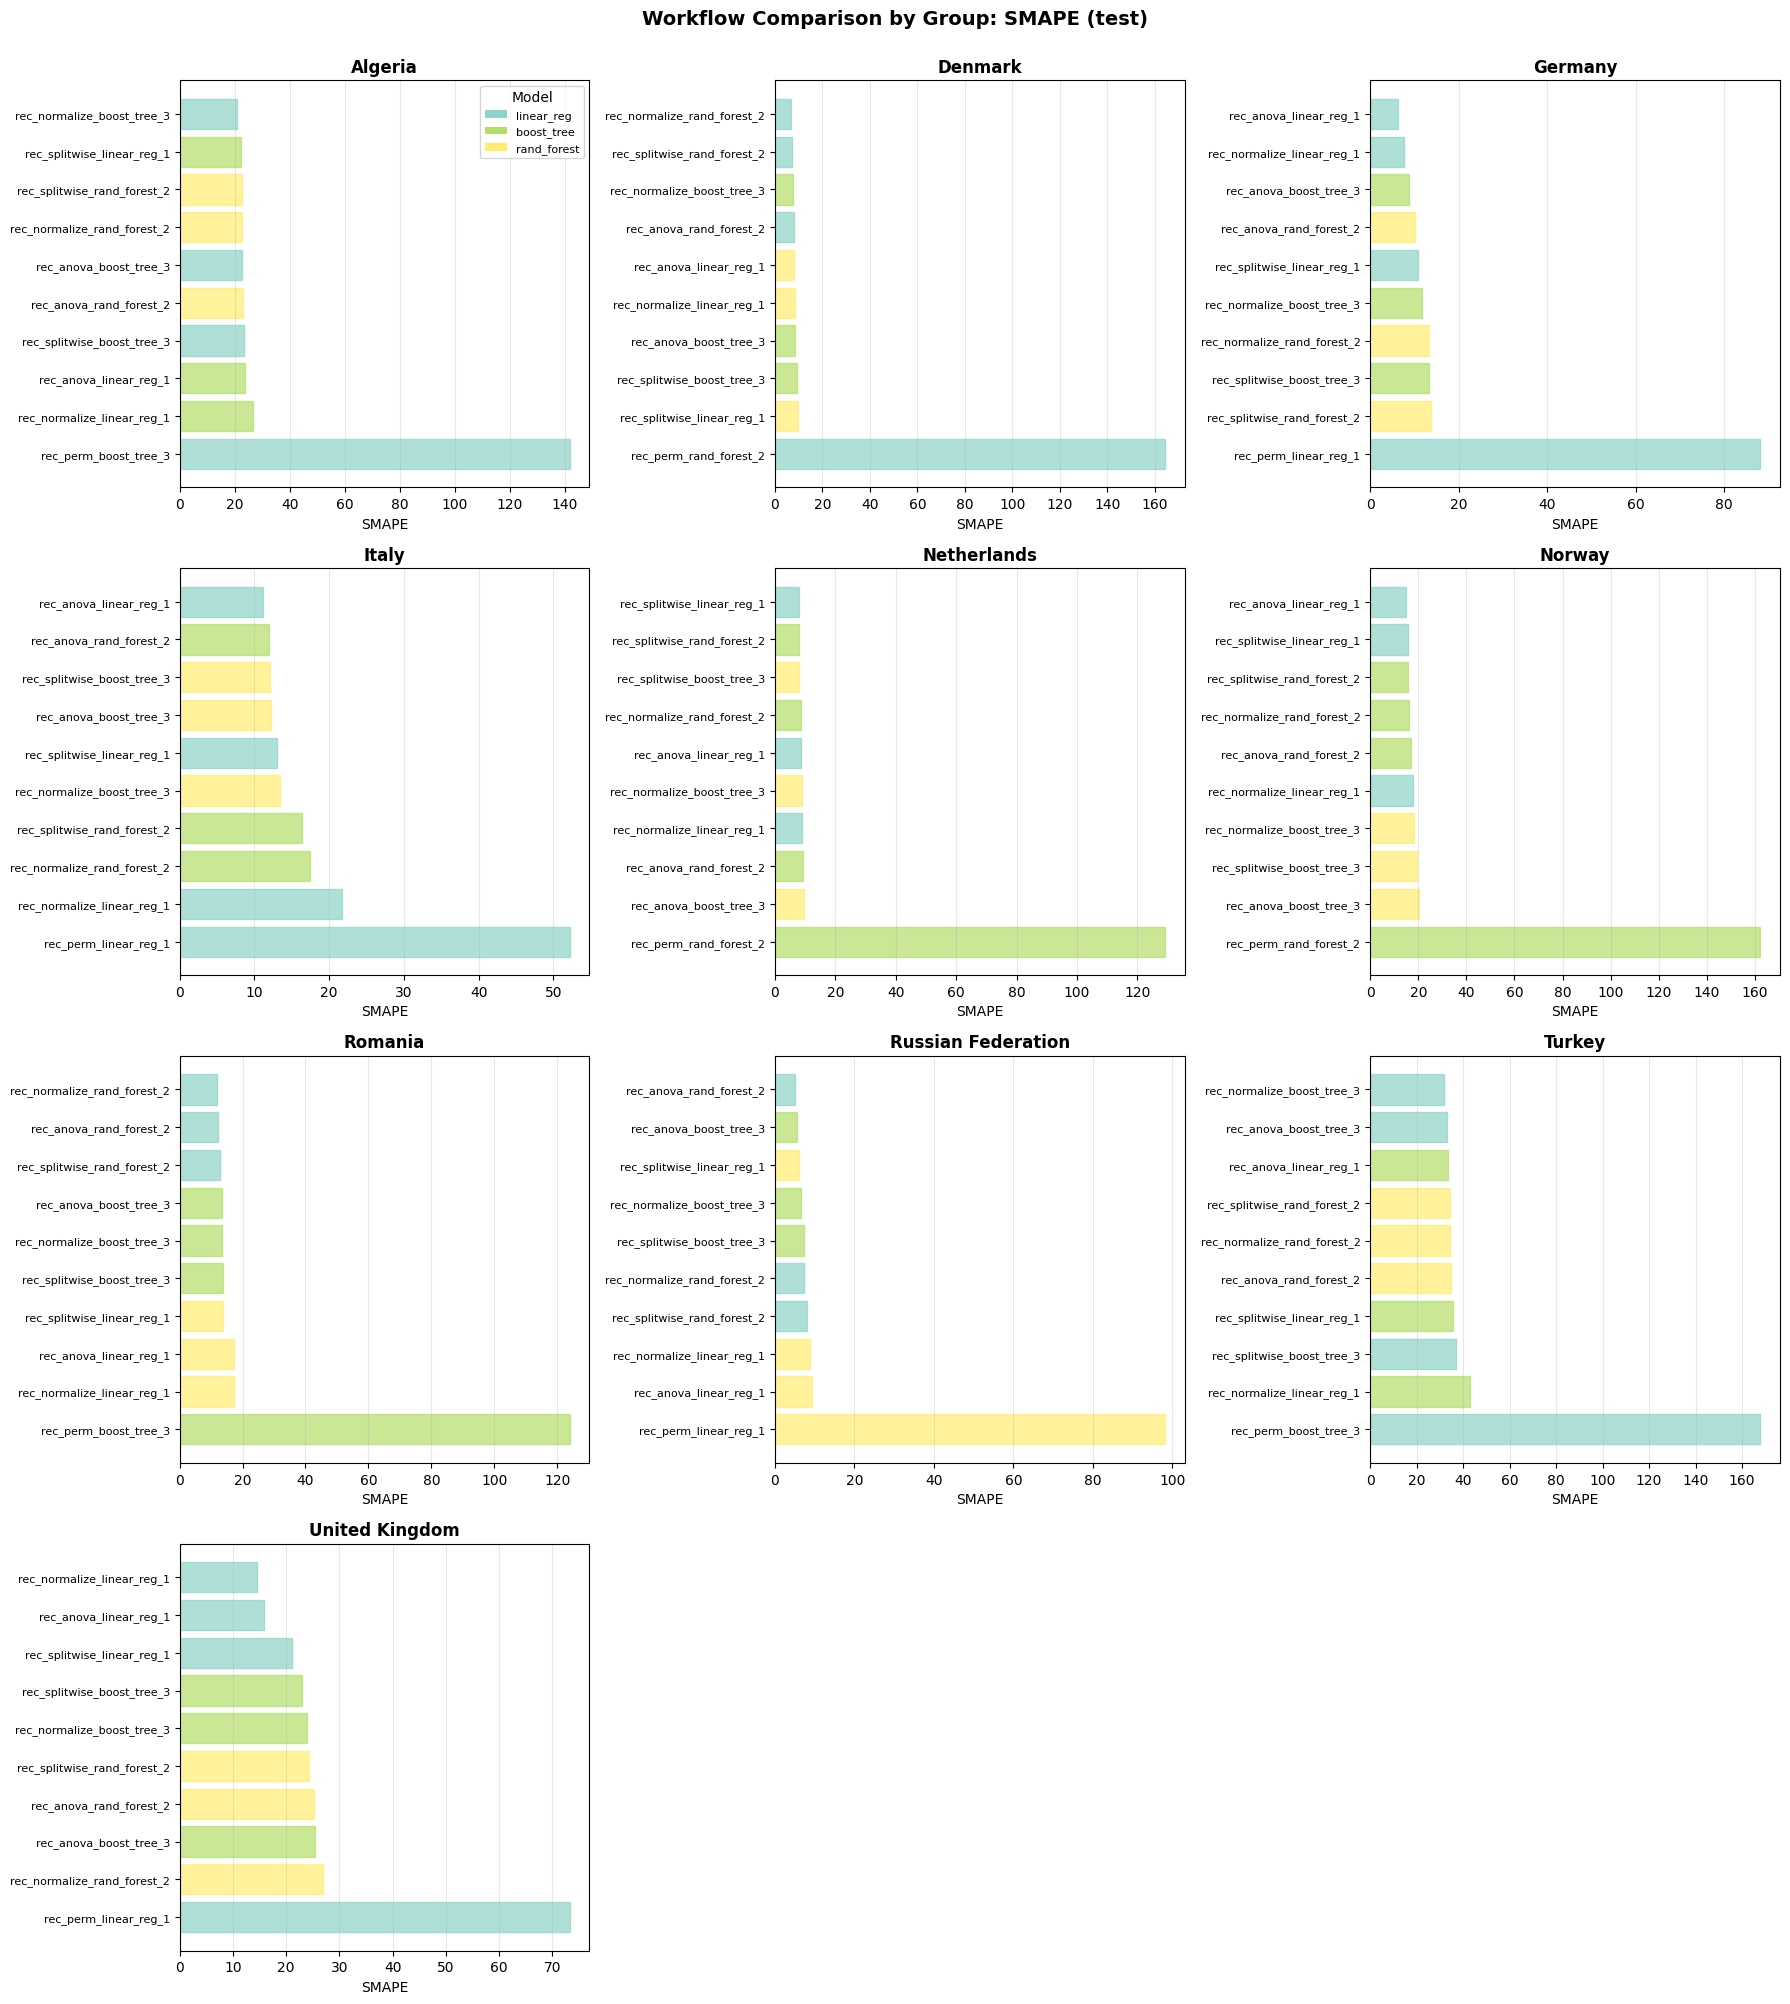


Shows average RMSE ± std across all groups


In [31]:
# Plot average performance with error bars
fig = results.autoplot('smape', split='test', by_group=True, top_n=10)
plt.show()

print("\nShows average RMSE ± std across all groups")

# autoplot - option with plotly and slicer

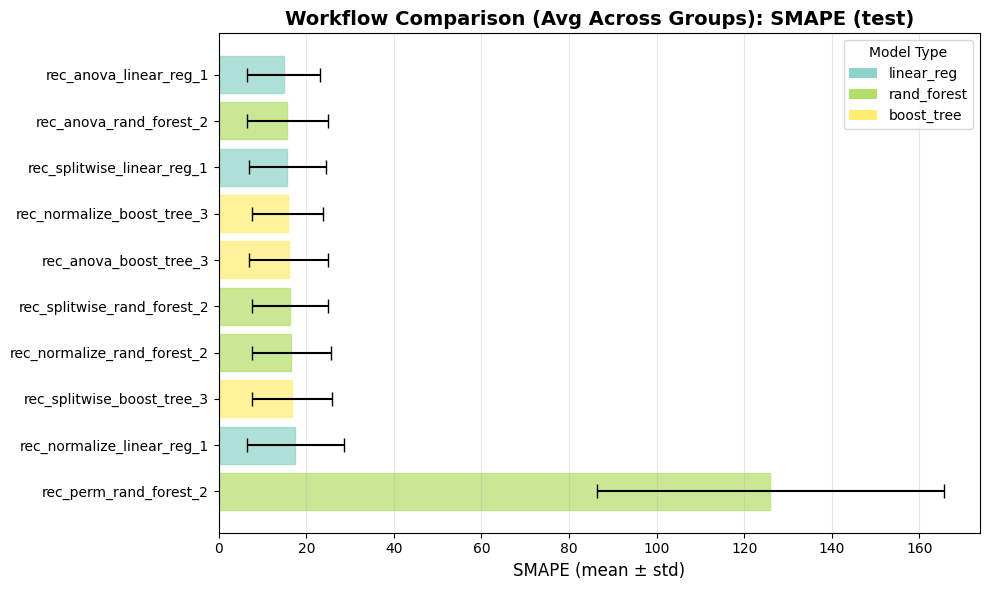


Shows average RMSE ± std across all groups


In [32]:
# Plot average performance with error bars
fig = results.autoplot('smape', split='test', by_group=False, top_n=10)
plt.show()

print("\nShows average RMSE ± std across all groups")

# autoplot - option with plotly and slicer

In [33]:
#  time series cv
from py_rsample import time_series_nested_cv

# Create rolling window CV
cv_folds = time_series_nested_cv(
    train_data,
    group_col='country',
    date_column='date',
    initial='60 months',
    assess='24 months',
    skip='24 months',
    cumulative=False,
    # slice_limit=10
)

display(cv_folds)

✓ Created CV splits for 10 groups (20 total folds)


{'Algeria': TimeSeriesCV(rolling window, 2 splits, initial=59, assess=23, lag=0),
 'Denmark': TimeSeriesCV(rolling window, 2 splits, initial=59, assess=23, lag=0),
 'Germany': TimeSeriesCV(rolling window, 2 splits, initial=59, assess=23, lag=0),
 'Italy': TimeSeriesCV(rolling window, 2 splits, initial=59, assess=23, lag=0),
 'Netherlands': TimeSeriesCV(rolling window, 2 splits, initial=59, assess=23, lag=0),
 'Norway': TimeSeriesCV(rolling window, 2 splits, initial=59, assess=23, lag=0),
 'Romania': TimeSeriesCV(rolling window, 2 splits, initial=59, assess=23, lag=0),
 'Russian Federation': TimeSeriesCV(rolling window, 2 splits, initial=59, assess=23, lag=0),
 'Turkey': TimeSeriesCV(rolling window, 2 splits, initial=59, assess=23, lag=0),
 'United Kingdom': TimeSeriesCV(rolling window, 2 splits, initial=59, assess=23, lag=0)}

In [34]:
metrics = metric_set(rmse, mae, mape, smape, r_squared)

# Evaluate workflows
cv_res = wf_set.fit_nested_resamples(
    resamples=cv_folds,
    metrics=metrics,
    group_col='country',
    verbose=True)

Fitting 12 workflows across 10 groups with CV...
Total evaluations: 12 workflows × 10 groups × avg 2 folds


[1/12] Workflow: rec_normalize_linear_reg_1
  [1/10] Group: Algeria (2 folds) ✓
  [2/10] Group: Denmark (2 folds) ✓
  [3/10] Group: Germany (2 folds) ✓
  [4/10] Group: Italy (2 folds) ✓
  [5/10] Group: Netherlands (2 folds) ✓
  [6/10] Group: Norway (2 folds) ✓
  [7/10] Group: Romania (2 folds) ✓
  [8/10] Group: Russian Federation (2 folds) ✓
  [9/10] Group: Turkey (2 folds) ✓
  [10/10] Group: United Kingdom (2 folds) ✓

[2/12] Workflow: rec_normalize_rand_forest_2
  [1/10] Group: Algeria (2 folds) ✓
  [2/10] Group: Denmark (2 folds) ✓
  [3/10] Group: Germany (2 folds) ✓
  [4/10] Group: Italy (2 folds) ✓
  [5/10] Group: Netherlands (2 folds) ✓
  [6/10] Group: Norway (2 folds) ✓
  [7/10] Group: Romania (2 folds) ✓
  [8/10] Group: Russian Federation (2 folds) ✓
  [9/10] Group: Turkey (2 folds) ✓
  [10/10] Group: United Kingdom (2 folds) ✓

[3/12] Workflow: rec_normalize_boost_tree_

In [35]:
metrics_all = cv_res.collect_metrics(summarize=False)
display(metrics_all)

,metric,value,.resample,.config,wflow_id,group,preprocessor,model
0,rmse,128.737321,Fold01,config_001,rec_normalize_linear_reg_1,Algeria,recipe,linear_reg
1,mae,81.662074,Fold01,config_001,rec_normalize_linear_reg_1,Algeria,recipe,linear_reg
2,mape,15.635070,Fold01,config_001,rec_normalize_linear_reg_1,Algeria,recipe,linear_reg
3,smape,22.372865,Fold01,config_001,rec_normalize_linear_reg_1,Algeria,recipe,linear_reg
4,r_squared,-0.365514,Fold01,config_001,rec_normalize_linear_reg_1,Algeria,recipe,linear_reg
...,...,...,...,...,...,...,...,...
1195,rmse,316.774994,Fold02,config_001,rec_splitwise_boost_tree_3,United Kingdom,recipe,boost_tree
1196,mae,302.478780,Fold02,config_001,rec_splitwise_boost_tree_3,United Kingdom,recipe,boost_tree
1197,mape,27.610476,Fold02,config_001,rec_splitwise_boost_tree_3,United Kingdom,recipe,boost_tree
1198,smape,23.893924,Fold02,config_001,rec_splitwise_boost_tree_3,United Kingdom,recipe,boost_tree


In [36]:
metric_cs = cv_res.collect_metrics(summarize=True)
display(metric_cs)

,wflow_id,group,metric,mean,std,n,preprocessor,model
0,rec_normalize_linear_reg_1,Algeria,mae,87.213155,7.850414,2,recipe,linear_reg
1,rec_normalize_linear_reg_1,Algeria,mape,13.922526,2.421902,2,recipe,linear_reg
2,rec_normalize_linear_reg_1,Algeria,r_squared,-0.406331,0.057723,2,recipe,linear_reg
3,rec_normalize_linear_reg_1,Algeria,rmse,137.546966,12.458720,2,recipe,linear_reg
4,rec_normalize_linear_reg_1,Algeria,smape,21.858597,0.727284,2,recipe,linear_reg
...,...,...,...,...,...,...,...,...
595,rec_splitwise_boost_tree_3,United Kingdom,mae,206.340537,135.960007,2,recipe,boost_tree
596,rec_splitwise_boost_tree_3,United Kingdom,mape,18.040958,13.533341,2,recipe,boost_tree
597,rec_splitwise_boost_tree_3,United Kingdom,r_squared,-10.864712,12.656001,2,recipe,boost_tree
598,rec_splitwise_boost_tree_3,United Kingdom,rmse,242.983566,104.356839,2,recipe,boost_tree


In [37]:
cv_ranked_by_group = cv_res.rank_results(
      metric='rmse',
      by_group=True,
      n=10  # Top 5 workflows per group
  )

display(cv_ranked_by_group)

,group,rank,wflow_id,mean,std,preprocessor,model
553,Algeria,1.0,rec_splitwise_boost_tree_3,109.138387,23.968657,recipe,boost_tree
103,Algeria,2.0,rec_normalize_boost_tree_3,118.074151,6.292302,recipe,boost_tree
253,Algeria,3.0,rec_anova_boost_tree_3,126.310449,20.374472,recipe,boost_tree
53,Algeria,4.0,rec_normalize_rand_forest_2,127.744526,29.969410,recipe,rand_forest
503,Algeria,5.0,rec_splitwise_rand_forest_2,129.149129,20.487393,recipe,rand_forest
...,...,...,...,...,...,...,...
548,United Kingdom,6.0,rec_splitwise_rand_forest_2,235.037406,107.803434,recipe,rand_forest
598,United Kingdom,7.0,rec_splitwise_boost_tree_3,242.983566,104.356839,recipe,boost_tree
298,United Kingdom,8.0,rec_anova_boost_tree_3,244.025364,116.722321,recipe,boost_tree
498,United Kingdom,9.0,rec_splitwise_linear_reg_1,260.744577,56.298458,recipe,linear_reg


In [38]:
# Cell 71: Fit on full training data
results = wf_set.fit_nested(train_data, group_col='country', per_group_prep=True)
outputs, coefs, wfset_stats = results.extract_outputs()

# Cell 82: Evaluate with CV
cv_res = wf_set.fit_nested_resamples(
    resamples=cv_folds,
    metrics=metrics,
    group_col='country',
    verbose=True
)


Fitting rec_normalize_linear_reg_1 across all groups...
Fitting rec_normalize_rand_forest_2 across all groups...
Fitting rec_normalize_boost_tree_3 across all groups...
Fitting rec_anova_linear_reg_1 across all groups...
Fitting rec_anova_rand_forest_2 across all groups...
Fitting rec_anova_boost_tree_3 across all groups...
Fitting rec_perm_linear_reg_1 across all groups...
Fitting rec_perm_rand_forest_2 across all groups...
Fitting rec_perm_boost_tree_3 across all groups...
Fitting rec_splitwise_linear_reg_1 across all groups...


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_parsnip/engines/sklearn_linear_reg.py:460: RuntimeWarning:

invalid value encountered in sqrt



Fitting rec_splitwise_rand_forest_2 across all groups...
Fitting rec_splitwise_boost_tree_3 across all groups...
Fitting 12 workflows across 10 groups with CV...
Total evaluations: 12 workflows × 10 groups × avg 2 folds


[1/12] Workflow: rec_normalize_linear_reg_1
  [1/10] Group: Algeria (2 folds) ✓
  [2/10] Group: Denmark (2 folds) ✓
  [3/10] Group: Germany (2 folds) ✓
  [4/10] Group: Italy (2 folds) ✓
  [5/10] Group: Netherlands (2 folds) ✓
  [6/10] Group: Norway (2 folds) ✓
  [7/10] Group: Romania (2 folds) ✓
  [8/10] Group: Russian Federation (2 folds) ✓
  [9/10] Group: Turkey (2 folds) ✓
  [10/10] Group: United Kingdom (2 folds) ✓

[2/12] Workflow: rec_normalize_rand_forest_2
  [1/10] Group: Algeria (2 folds) ✓
  [2/10] Group: Denmark (2 folds) ✓
  [3/10] Group: Germany (2 folds) ✓
  [4/10] Group: Italy (2 folds) ✓
  [5/10] Group: Netherlands (2 folds) ✓
  [6/10] Group: Norway (2 folds) ✓
  [7/10] Group: Romania (2 folds) ✓
  [8/10] Group: Russian Federation (2 folds) ✓
  [9/10] 

In [39]:
# NEW: Cell 85 - Compare (ONE LINE!)
comparison = cv_res.compare_train_cv(wfset_stats)
display(comparison)

comparison.to_csv('comparison.csv', index=False)

metric,wflow_id,group,rmse_train,mae_train,r_squared_train,rmse_cv,mae_cv,r_squared_cv,rmse_overfit_ratio,mae_overfit_ratio,r_squared_generalization_drop,fit_quality
51,rec_normalize_rand_forest_2,Denmark,8.902015,6.186026,0.755632,19.599592,12.875150,0.049166,2.201703,2.081328,0.706466,🔴 Severe Overfit
101,rec_splitwise_linear_reg_1,Denmark,14.013209,10.264209,0.39446,20.114939,14.478732,-0.048096,1.435427,1.410604,0.442556,🟡 Moderate Overfit
21,rec_anova_rand_forest_2,Denmark,8.620134,5.982415,0.770863,20.780616,14.443083,-0.076662,2.410707,2.414256,0.847525,🔴 Severe Overfit
31,rec_normalize_boost_tree_3,Denmark,1.894563,1.4369,0.988932,21.090513,13.653680,-0.105380,11.132128,9.502179,1.094312,🔴 Severe Overfit
111,rec_splitwise_rand_forest_2,Denmark,9.916586,7.001769,0.696756,21.440014,13.385128,-0.188417,2.162036,1.911678,0.885173,🔴 Severe Overfit
...,...,...,...,...,...,...,...,...,...,...,...,...
62,rec_perm_boost_tree_3,Germany,0.155773,0.114479,0.975735,1919.491798,1918.006172,-731.402883,12322.38058,16754.202051,732.378618,🔴 Severe Overfit
82,rec_perm_rand_forest_2,Germany,0.339165,0.241962,0.884967,1919.671000,1918.185564,-731.525118,5659.991558,7927.636461,732.410086,🔴 Severe Overfit
87,rec_perm_rand_forest_2,Russian Federation,0.249364,0.181176,0.937818,5523.048896,5519.085043,-712.352035,22148.527442,30462.52046,713.289852,🔴 Severe Overfit
67,rec_perm_boost_tree_3,Russian Federation,0.128235,0.093892,0.983556,5523.151730,5519.189332,-712.386423,43070.699532,58782.425215,713.369979,🔴 Severe Overfit


In [40]:
# Find overfitting workflows
overfit = comparison[comparison['rmse_overfit_ratio'] > 1.2]
print(f"⚠️  {len(overfit)} workflows show overfitting")

# Best per group
best = comparison.sort_values('rmse_cv').groupby('group').first()

⚠️  118 workflows show overfitting


In [41]:
display(best)

metric,wflow_id,rmse_train,mae_train,r_squared_train,rmse_cv,mae_cv,r_squared_cv,rmse_overfit_ratio,mae_overfit_ratio,r_squared_generalization_drop,fit_quality
group,,,,,,,,,,,
Algeria,rec_splitwise_boost_tree_3,12.703567,9.928946,0.983313,109.138387,78.967559,0.057973,8.591161,7.953267,0.92534,🔴 Severe Overfit
Denmark,rec_normalize_rand_forest_2,8.902015,6.186026,0.755632,19.599592,12.875150,0.049166,2.201703,2.081328,0.706466,🔴 Severe Overfit
Germany,rec_normalize_rand_forest_2,51.654696,39.008648,0.904294,158.587124,137.672689,-3.537073,3.07014,3.529286,4.441367,🔴 Severe Overfit
Italy,rec_splitwise_linear_reg_1,119.369678,96.318254,0.738526,257.910188,227.783455,-8.529797,2.160601,2.364904,9.268322,🔴 Severe Overfit
Netherlands,rec_anova_boost_tree_3,13.795007,10.059534,0.968668,71.504883,50.080842,-0.134557,5.183389,4.978446,1.103225,🔴 Severe Overfit
Norway,rec_splitwise_rand_forest_2,21.658587,12.96004,0.723928,27.459833,23.150832,-1.292342,1.26785,1.786324,2.01627,🟡 Moderate Overfit
Romania,rec_anova_linear_reg_1,30.686158,23.959917,0.408053,37.941954,33.692770,-1.715452,1.236452,1.406214,2.123505,🟡 Moderate Overfit
Russian Federation,rec_normalize_linear_reg_1,224.371177,178.563022,0.819577,468.376386,399.582924,-4.437138,2.087507,2.23777,5.256715,🔴 Severe Overfit
Turkey,rec_normalize_linear_reg_1,42.232017,33.725954,0.712836,64.496725,56.354595,-1.338093,1.5272,1.670956,2.050929,🔴 Severe Overfit
